In [1]:
import numpy as np
import scipy.linalg
from scipy.special import softmax
from sampling import Sampling
import sys

class Simulation:
    """
    Simulation framework for multi-frame survey sampling.
    
    Includes:
    - Population generation
    - Sample extraction from frames
    - Estimation (SM, PML, NPML) following Lohr & Rao (2006, JASA).
    """

    def __init__(self, params: dict = None, reproduce= True):
        """
        Initialize the simulation with default or user-specified parameters.
        
        Parameters
        ----------
        params : dict, optional
            Dictionary of simulation parameters. If None, defaults are used.
        """
        self.params = params if params is not None else self.get_parameters()
        self.reproduce= reproduce
        
    def get_parameters(self):
        """
        Returns the default simulation parameters.
        
        Returns
        -------
        dict
        """
        return {
            'Q': 3,
            'N': 1000,
            'Nrun': 100,
            'my': 100,
            'mx': 400,
            'sy': 9,
            'sx': 4,
            'royx': 0.85,
            'mean': [100, 400],
            'cov': [
                [9**2, 0.85*9*4],
                [0.85*9*4, 4**2],
            ],
            'random_seed': 6,
            'Nd_pct': [0.3, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1],
            'sample_design': ["srs", "sampford", "sampford"],
            'fq': [0.05, 0.05, 0.05],
        }

    def generate_population(self):
        """
        Generate a synthetic population with overlapping domains and frames.
        
        Returns
        -------
        dict
            Dictionary containing the simulated population structure and values.
        """
        p = self.params

        if self.reproduce:
            print("ole")
            np.random.seed(p['random_seed'])

        Q, N = p['Q'], p['N']
        mean, cov = np.array(p['mean']), np.array(p['cov'])
        Nd_pct = np.array(p['Nd_pct'])

        D = 2**Q - 1
        d = np.arange(1, D+1)
        q = np.arange(1, Q+1)

        # Domain-frame incidence matrix
        dBinary = np.array([list(map(int, np.binary_repr(i, Q)[::-1])) for i in range(1, D+1)])
        md = dBinary.sum(axis=1)

        # Generate (y, x) > 0
        yx = []
        while len(yx) < N:
            vals = np.random.multivariate_normal(mean, cov)
            if np.all(vals > 0):
                yx.append(vals)
        yx = np.array(yx) / 100.0
        y, x = yx[:, 0], yx[:, 1]

        # Mean checks
        assert np.isclose(y.mean()*100, p['my'], atol=2)
        assert np.isclose(x.mean()*100, p['mx'], atol=8)

        # Domain sizes
        Nd = np.round(Nd_pct * N).astype(int)
        diff = N - Nd.sum()
        if diff != 0:
            Nd[0] += diff
        assert Nd.sum() == N

        # Assign units to domains
        labels = np.arange(N)
        np.random.shuffle(labels)
        domains, start = [], 0
        for nd in Nd:
            domains.append(labels[start:start+nd].tolist())
            start += nd

        # Frame sizes
        Nq = []
        for iq in range(Q):
            mask = dBinary[:, iq] == 1
            Nq.append(sum([Nd[idom] for idom in range(D) if mask[idom]]))

        # Frame membership
        frames = []
        for iq in range(Q):
            idxs = []
            for idom in range(D):
                if dBinary[idom, iq] == 1:
                    idxs.extend(domains[idom])
            frames.append(sorted(idxs))

        # Values by frame
        x_kq = [[x[i] for i in frame] for frame in frames]
        y_kq = [[y[i] for i in frame] for frame in frames]

        # Totals
        T_y, T_x = y.sum(), x.sum()
        T_yd = [y[domains[idom]].sum() for idom in range(D)]
        T_xd = [x[domains[idom]].sum() for idom in range(D)]

        # Multiplicities
        m_kq = []
        for iq in range(Q):
            mkq = []
            for idom in range(D):
                if dBinary[idom, iq] == 1:
                    mkq += [md[idom]] * len(domains[idom])
            m_kq.append(mkq)

        # Domain membership matrix
        domain_kd = np.zeros((N, D), dtype=int)
        for idom, dom in enumerate(domains):
            domain_kd[dom, idom] = 1

        # Group list g = (group index, domain, frame)
        g_list, g = [], 1
        for idom in range(D):
            for iq in range(Q):
                if dBinary[idom, iq] == 1:
                    g_list.append((g, idom+1, iq+1))
                    g += 1

        return {
            'Q': Q, 'D': D, 'N': N, 'd': d, 'q': q, 'dBinary': dBinary, 'md': md,
            'y': y, 'x': x, 'domains': domains, 'frames': frames,
            'x_kq': x_kq, 'y_kq': y_kq, 'T_y': T_y, 'T_x': T_x,
            'T_yd': T_yd, 'T_xd': T_xd, 'Nq': Nq, 'Nd': Nd,
            'm_kq': m_kq, 'domain_kd': domain_kd, 'g_list': g_list
        }

    def extract_sample(self, population):
        """
        Extracts samples from each frame according to the chosen designs.
        
        Parameters
        ----------
        population : dict
            The dictionary produced by `generate_population`.
        
        Returns
        -------
        dict
            Dictionary containing selected units, inclusion probabilities, and frame-domain splits.
        """
        p, Q = self.params, population['Q']
        Nq, frames, x_kq, y_kq, m_kq_pop = population['Nq'], population['frames'], population['x_kq'], population['y_kq'], population['m_kq']
        nq = [int(np.ceil(Nq[q] * p['fq'][q])) for q in range(Q)]
        random_seed = p['random_seed']
        sample_designs = p['sample_design']

        # Storage
        s_q, pi_kq_pop, pi_kq, pi_klq, m_kq, rejects_q = [], [], [], [], [], []

        for q in range(Q):
            design = sample_designs[q] if isinstance(sample_designs, list) else sample_designs
            N = len(frames[q])
            n = nq[q]
            x = x_kq[q] if design in ("pareto", "sampford") else None

            sampling = Sampling.Make(design, N=N, n=n, x=x)
            if self.reproduce:
                sample, rejects = sampling.get_sample(seed=random_seed + q)
            else:
                sample, rejects = sampling.get_sample()
            
            s_q.append(sample)
            rejects_q.append(rejects)
            pi_kq_pop.append(list(sampling.get_πi()))
            pi_kq.append(list(sampling.get_πi_sample(sample)))
            pi_klq.append(sampling.get_πij_sample(sample))
            m_kq.append([m_kq_pop[q][i] for i in sample])

        # Classify into domain-frame subsamples
        dBinary, D, domains = population['dBinary'], population['D'], population['domains']
        s_dq, d_q = [], []
        for idom in range(D):
            for iq in range(Q):
                if dBinary[idom, iq] == 1:
                    frame_idxs = frames[iq]
                    dom_set = set(domains[idom])
                    sample = s_q[iq]
                    idxs_in_dom = [i for i, idx in enumerate(sample) if frame_idxs[idx] in dom_set]
                    s_dq.append(idxs_in_dom)
                    d_q.append((idom, iq))

        n_dq = [len(idxs) for idxs in s_dq]

        return {
            's_q': s_q,
            'pi_kq_pop': pi_kq_pop,
            'pi_kq': pi_kq,
            'pi_klq': pi_klq,
            'm_kq': m_kq,
            'nq': nq,
            'frames': frames,
            'x_kq': x_kq,
            'y_kq': y_kq,
            's_dq': s_dq,
            'd_q': d_q,
            'n_dq': n_dq,
            'rejects_q': rejects_q,
            'pop': population
        }

    def compute_estimates(self, sample):
        """
        Computes SM, PML, and NPML estimates from the drawn sample.
        
        Parameters
        ----------
        sample : dict
            Output of `extract_sample`.
        
        Returns
        -------
        dict
            Dictionary of estimates and intermediate quantities.
        """

        
        pop = sample['pop']
        Q = pop['Q']
        D = pop['D']
        dBinary = pop['dBinary']
        md = pop['md']
        nq = sample['nq']
        Nq = pop['Nq']
        deff = np.ones(Q)  # deff placeholder (efficienza disegno)
        s_q = sample['s_q']
        pi_kq = sample['pi_kq']
        m_kq = sample['m_kq']
        y_kq = sample['y_kq']
        # DESIGN WEIGHTS
        w_kq = [[1/pi for pi in pi_kq[q]] for q in range(Q)]
        # UNIT MULTIPLICITY (dal pop)
        m_kq_full = [[m for m in m_kq[q]] for q in range(Q)]
        # DOMAIN MULTIPLICITY
        md_vec = md.copy()  # D
        # ALPHA (SIMPLE MULTIPLICITY ADJUSTMENT)
        alpha_kq = [[1/m for m in m_kq[q]] for q in range(Q)]
        
        # SIMPLE MULTIPLICITY ESTIMATOR
        Y_SM = sum(
            y_kq[q][j] * alpha_kq[q][j] * w_kq[q][j]
            for q in range(Q)
            for j in range(len(s_q[q]))
        )
        # --- PML ESTIMATOR ---
        # Nhat_q: somma pesi per frame
        Nhat_q = [sum(w_kq[q]) for q in range(Q)]
        # Nhat_d|q: somma pesi per ogni dominio d in ogni frame q
        # g_list: (g, id, iq) per ogni dominio-frame
        g_list = pop['g_list']
        Nhat_dq = []
        y_dq = []
        wPML_kdq = []
        for g, id, iq in g_list:
            q = iq-1
            d = id-1
            # print(f"g={g}, d={1+d}, q={1+q}")
            # trova indici del campione s_q che sono nel dominio d
            dom_idx = [i for i, k in enumerate(s_q[q]) if pop['domain_kd'][pop['frames'][q][k], d] == 1]
            # print(dom_idx)
            Nhat = sum(w_kq[q][i] for i in dom_idx)
            Nhat_dq.append(Nhat)
            ysum = sum(y_kq[q][i] for i in dom_idx)
            y_dq.append(ysum)
            # placeholder per pesi PML (da aggiornare dopo NPML)
            wPML_kdq.append([0.0 for _ in dom_idx])
        # Hhat_d|q: matrice D x Q, copia di dBinary, poi aggiornata con Nhat_g
        Hhat_dq = dBinary.copy().astype(float)
        g_idx = 0
        for d in range(D):
            for q in range(Q):
                if dBinary[d, q] == 1:
                    Hhat_dq[d, q] = Nhat_dq[g_idx]
                    g_idx += 1
        # NPML0: per ogni d, prendi Hhat_dq[d, q] dove n_d|q massimo
        NPML0 = np.zeros(D)
        for d in range(D):
            idx_q = np.where(dBinary[d] == 1)[0]
            if len(idx_q) == 1:
                NPML0[d] = Hhat_dq[d, idx_q[0]]
            else:
                # prendi q con massimo campione
                n_dq = [sum([pop['domain_kd'][pop['frames'][q][k], d] for k in s_q[q]]) for q in idx_q]
                qmax = idx_q[np.argmax(n_dq)]
                NPML0[d] = Hhat_dq[d, qmax]
        # Iterative routine Lohr & Rao (JASA 2006)
        Mplus = scipy.linalg.pinv(dBinary)
        fdeff = [nq[q] / Nq[q] / deff[q] for q in range(Q)]
        def A(x):
            A1 = (np.identity(D) - dBinary @ Mplus) @ scipy.linalg.inv(np.diag(x)) @ np.diag(dBinary @ fdeff)
            A2 = dBinary.T
            return np.concatenate((A1, A2))
        def b(x):
            b1 = (np.identity(D) - dBinary @ Mplus) @ scipy.linalg.inv(np.diag(x)) @ Hhat_dq @ fdeff
            b2 = np.array(Nq)
            return np.concatenate((b1, b2))
        Ncheck_d = np.zeros(D)
        x_old = np.array(NPML0)
        for _ in range(25):
            try:
                A_mat = A(x_old)
                b_vec = b(x_old)
                x_new = np.linalg.pinv(A_mat) @ b_vec
            except Exception:
                x_new = x_old
            if np.allclose(x_old, x_new):
                break
            x_old = x_new
        NPML_d = x_new
        # PML weights per g (dominio-frame)
        wPML_kdq = []
        g_idx = 0
        for g, id, iq in g_list:
            q = iq-1
            d = id-1
            # print(f"g={g}, d={1+d}, q={1+q}")
            dom_idx = [i for i, k in enumerate(s_q[q]) if pop['domain_kd'][pop['frames'][q][k], d] == 1]
            Nhat = Nhat_dq[g_idx]
            wPML = [NPML_d[d] * w_kq[q][i] / Nhat if Nhat > 0 else 0.0 for i in dom_idx]
            wPML_kdq.append(wPML)
            g_idx += 1
        # t_ywPML_g: somma y_kq * wPML_kdq per g
        t_ywPML_g = []
        g_idx = 0
        for g, id, iq in g_list:
            q = iq-1
            d = id-1
            dom_idx = [i for i, k in enumerate(s_q[q]) if pop['domain_kd'][pop['frames'][q][k], d] == 1]
            t_yw = sum(y_kq[q][i] * wPML_kdq[g_idx][j] for j, i in enumerate(dom_idx))
            t_ywPML_g.append(t_yw)
            g_idx += 1
        # PML alpha (pPML_g)
        pPML_g = []
        for g, id, iq in g_list:
            d = id-1
            idx_q = np.where(dBinary[d] == 1)[0]
            if md[d] == 1:
                pPML_g.append(1.0)
            elif md[d] == 2:
                q1, q2 = idx_q
                f1 = fdeff[q1] * Hhat_dq[d, q1]
                f2 = fdeff[q2] * Hhat_dq[d, q2]
                if iq-1 == q1:
                    pPML_g.append(f1 / (f1 + f2) if (f1+f2)>0 else 0.5)
                else:
                    pPML_g.append(f2 / (f1 + f2) if (f1+f2)>0 else 0.5)
            elif md[d] == 3:
                q1, q2, q3 = idx_q
                f1 = fdeff[q1] * Hhat_dq[d, q1]
                f2 = fdeff[q2] * Hhat_dq[d, q2]
                f3 = fdeff[q3] * Hhat_dq[d, q3]
                tot = f1 + f2 + f3
                if iq-1 == q1:
                    pPML_g.append(f1 / tot if tot>0 else 1/3)
                elif iq-1 == q2:
                    pPML_g.append(f2 / tot if tot>0 else 1/3)
                else:
                    pPML_g.append(f3 / tot if tot>0 else 1/3)
            else:
                pPML_g.append(1.0/md[d])
        # PML ESTIMATE
        Y_PML = sum(pPML_g[g] * t_ywPML_g[g] for g in range(len(g_list)))
        return {
            'Y_SM': Y_SM,
            'w_kq': w_kq,
            'm_kq': m_kq_full,
            'md': md_vec,
            'alpha_kq': alpha_kq,
            'Nhat_q': Nhat_q,
            'Nhat_dq': Nhat_dq,
            'Hhat_dq': Hhat_dq,
            'NPML0': NPML0,
            'NPML_d': NPML_d,
            'wPML_kdq': wPML_kdq,
            't_ywPML_g': t_ywPML_g,
            'pPML_g': pPML_g,
            'Y_PML': Y_PML
        }
        

    def run_pipeline(self):
        """
        Full simulation pipeline: population → sample → estimates.
        
        Returns
        -------
        dict
        """
        pop = self.generate_population()
        sample = self.extract_sample(pop)
        estimates = self.compute_estimates(sample)
        return {'population': pop, 'sample': sample, 'estimates': estimates}


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

simulation = Simulation()

In [3]:
# here's the results of the simulation
simulation_results = simulation.run_pipeline()

ole


In [4]:
simulation_results["estimates"]

{'Y_SM': np.float64(1008.9179802403828),
 'w_kq': [[np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0),
   np.float64(20.0)],
  [np.float64(20.298327516358377),
   np.float64(19.935960781969687),
   np.float64(19.92190333188504),
   np.float64(20.109400776916328),
   np.float64(20.269367197649682),
   np.float64(20.081078104254907),
   np.float64(19.925562534276814),
   np.float64(20.151105205227942),
   np.float64(19.572930539425467),
   np.

In [5]:
# your main results
data = pd.DataFrame({
    "var_1": simulation_results["population"]["x"],
    "var_2": simulation_results["population"]["y"]
})

# your groups (list of index lists)
tag_groups = simulation_results["population"]["domains"]

# create names for them
tag_names = [f"domain_{i+1}" for i in range(len(tag_groups))]

# build mapping from row index → tag
records = []
for tag, indices in zip(tag_names, tag_groups):
    for idx in indices:
        records.append((idx, tag))

df_tags = pd.DataFrame(records, columns=["index", "tag"])

# merge with data
df_with_tags = data.reset_index().merge(df_tags, on="index")

df_with_tags

,index,var_1,var_2,tag
0,0,4.024411,1.022687,domain_7
1,1,3.975826,0.986974,domain_4
2,2,4.105176,1.216467,domain_1
3,3,3.932236,0.909864,domain_3
4,4,3.933812,0.856058,domain_7
...,...,...,...,...
995,995,4.034297,1.109009,domain_4
996,996,4.008765,1.044724,domain_1
997,997,3.925647,0.826733,domain_2
998,998,3.998613,0.973083,domain_1


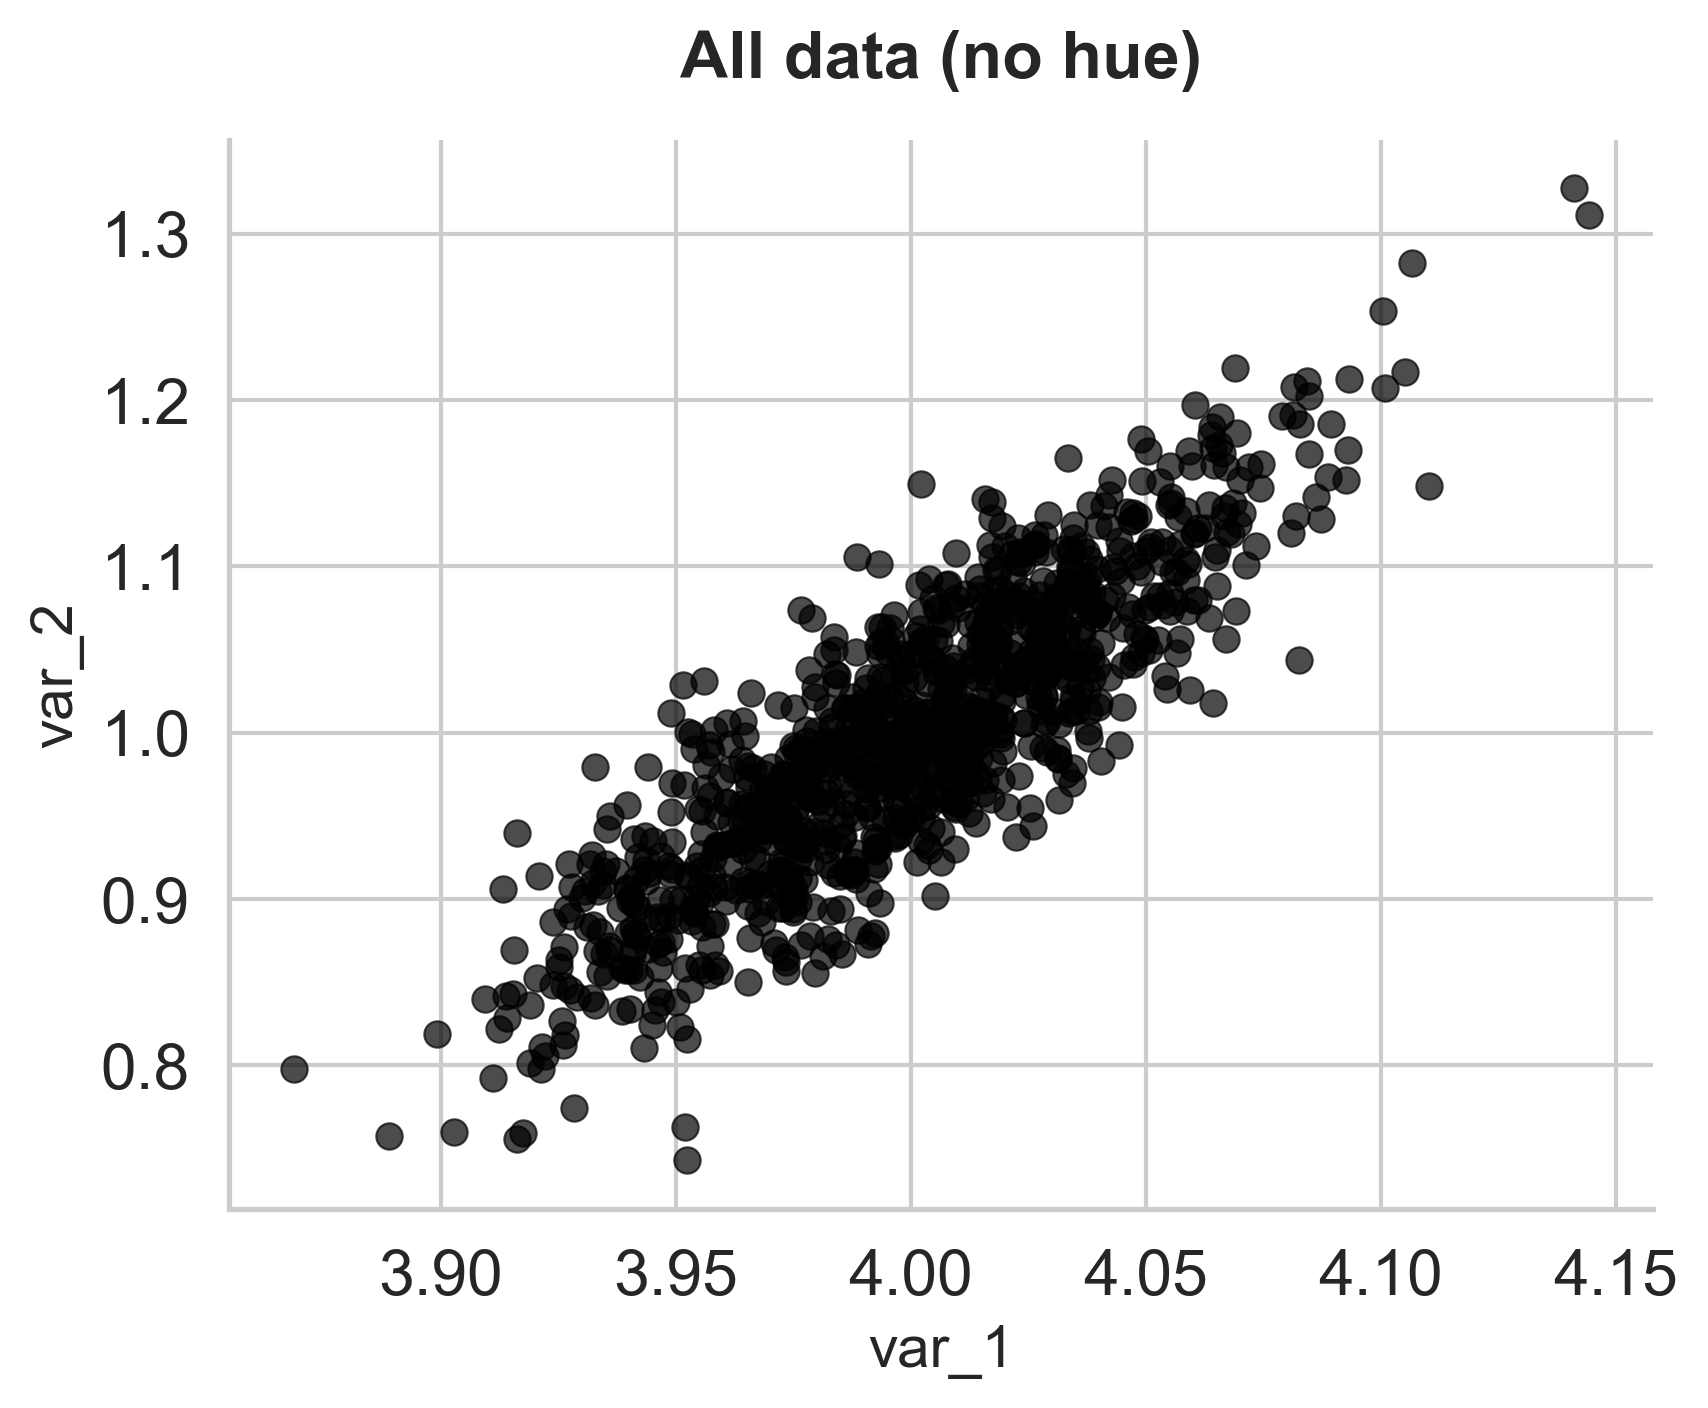

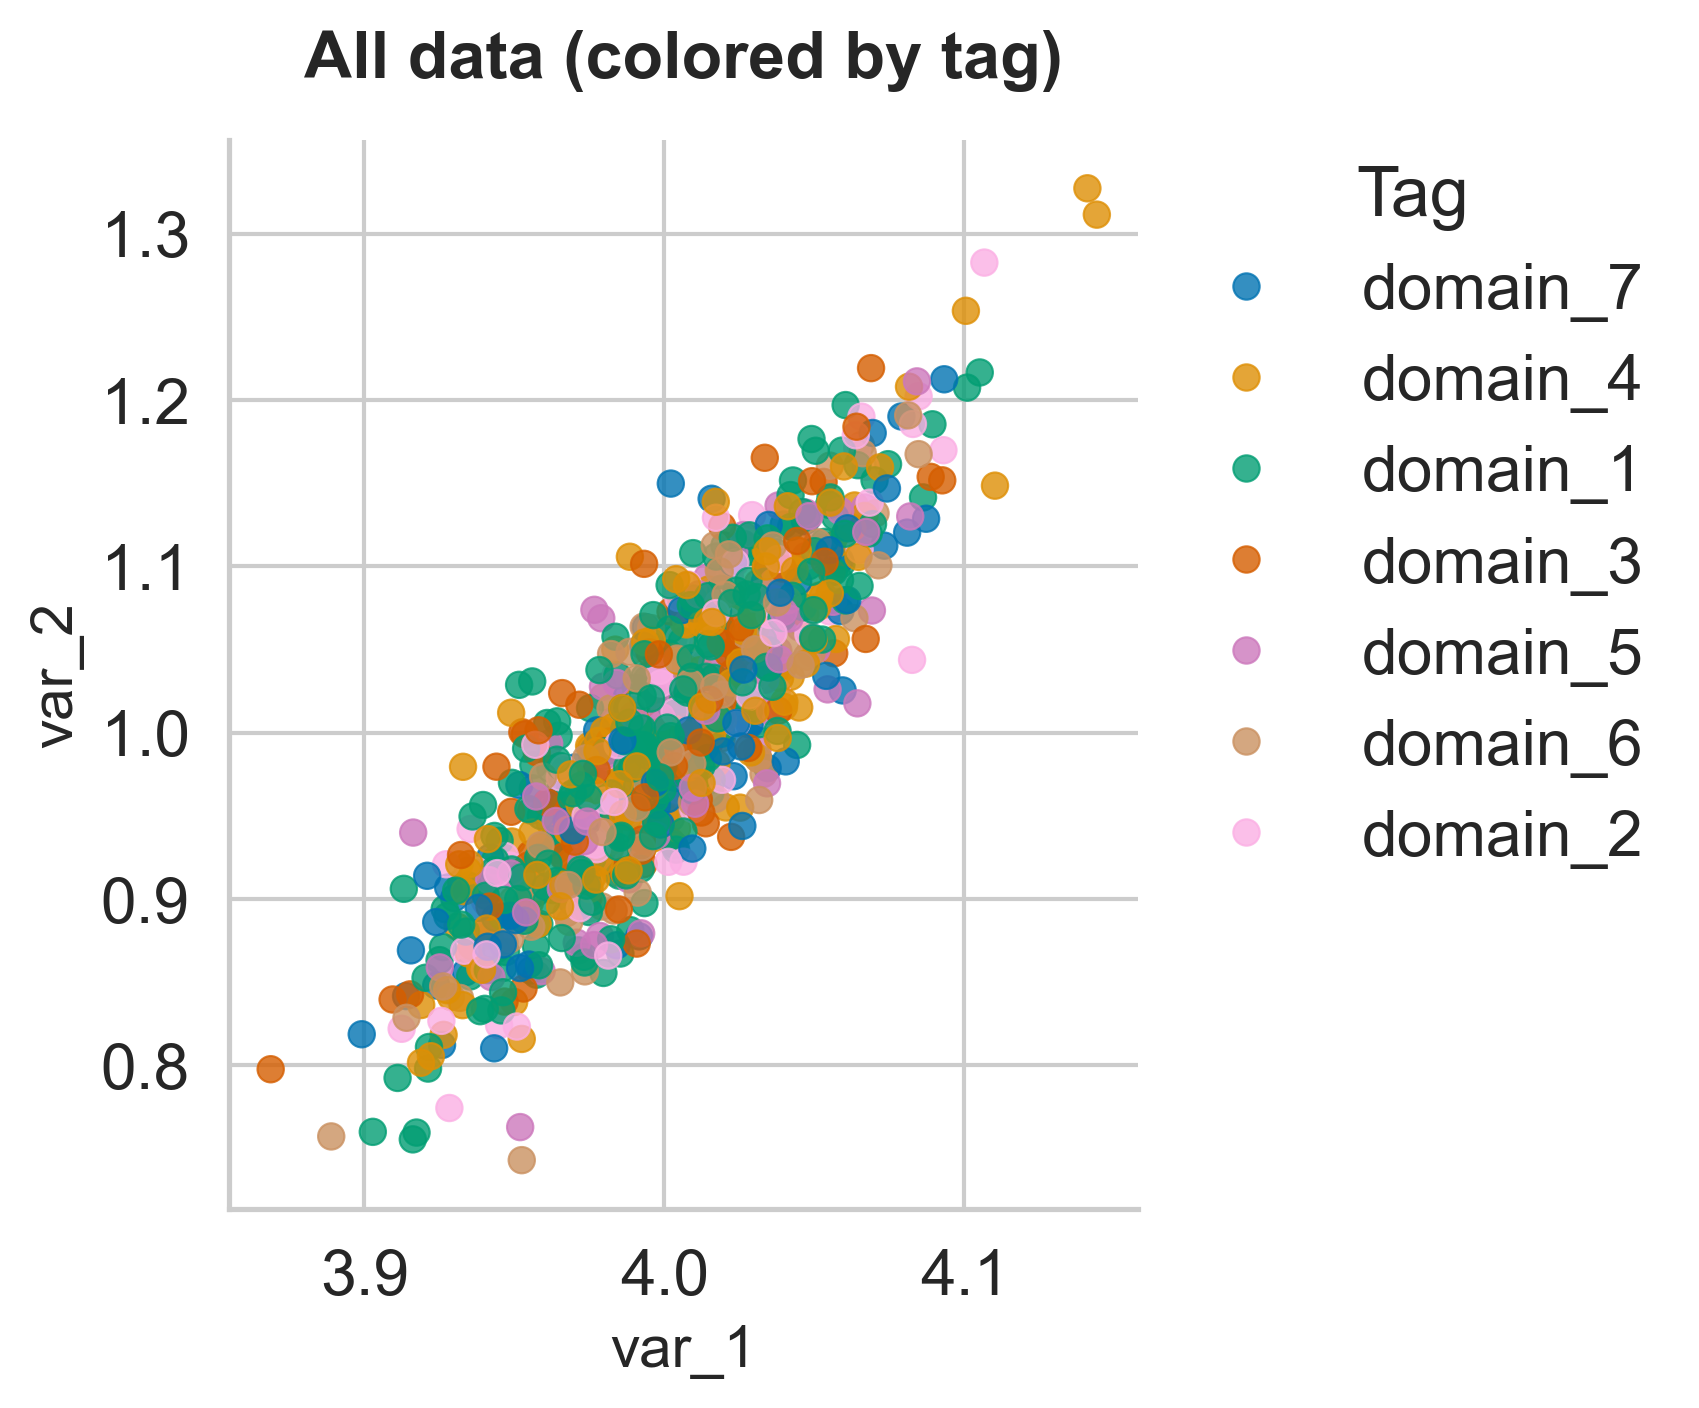

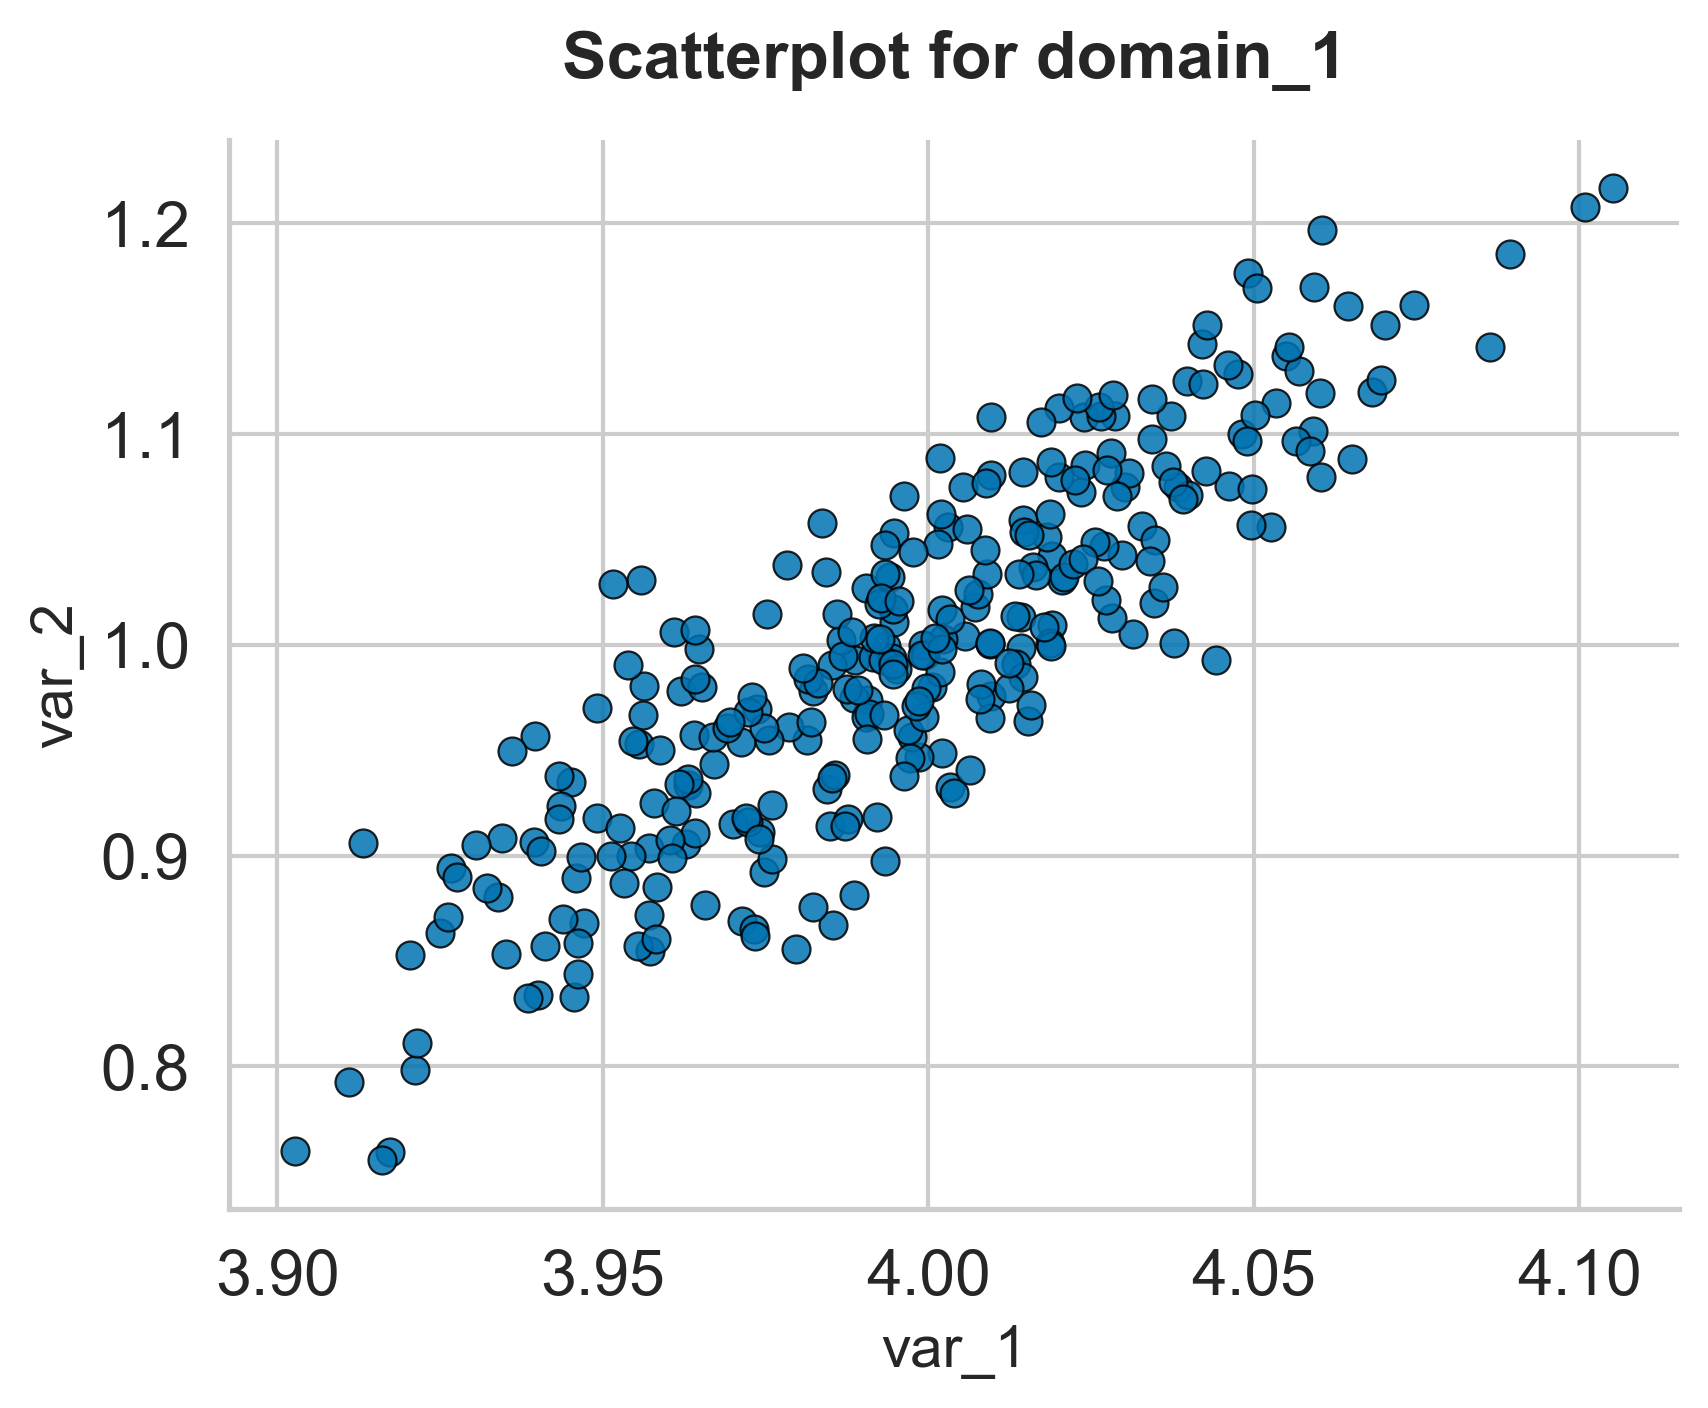

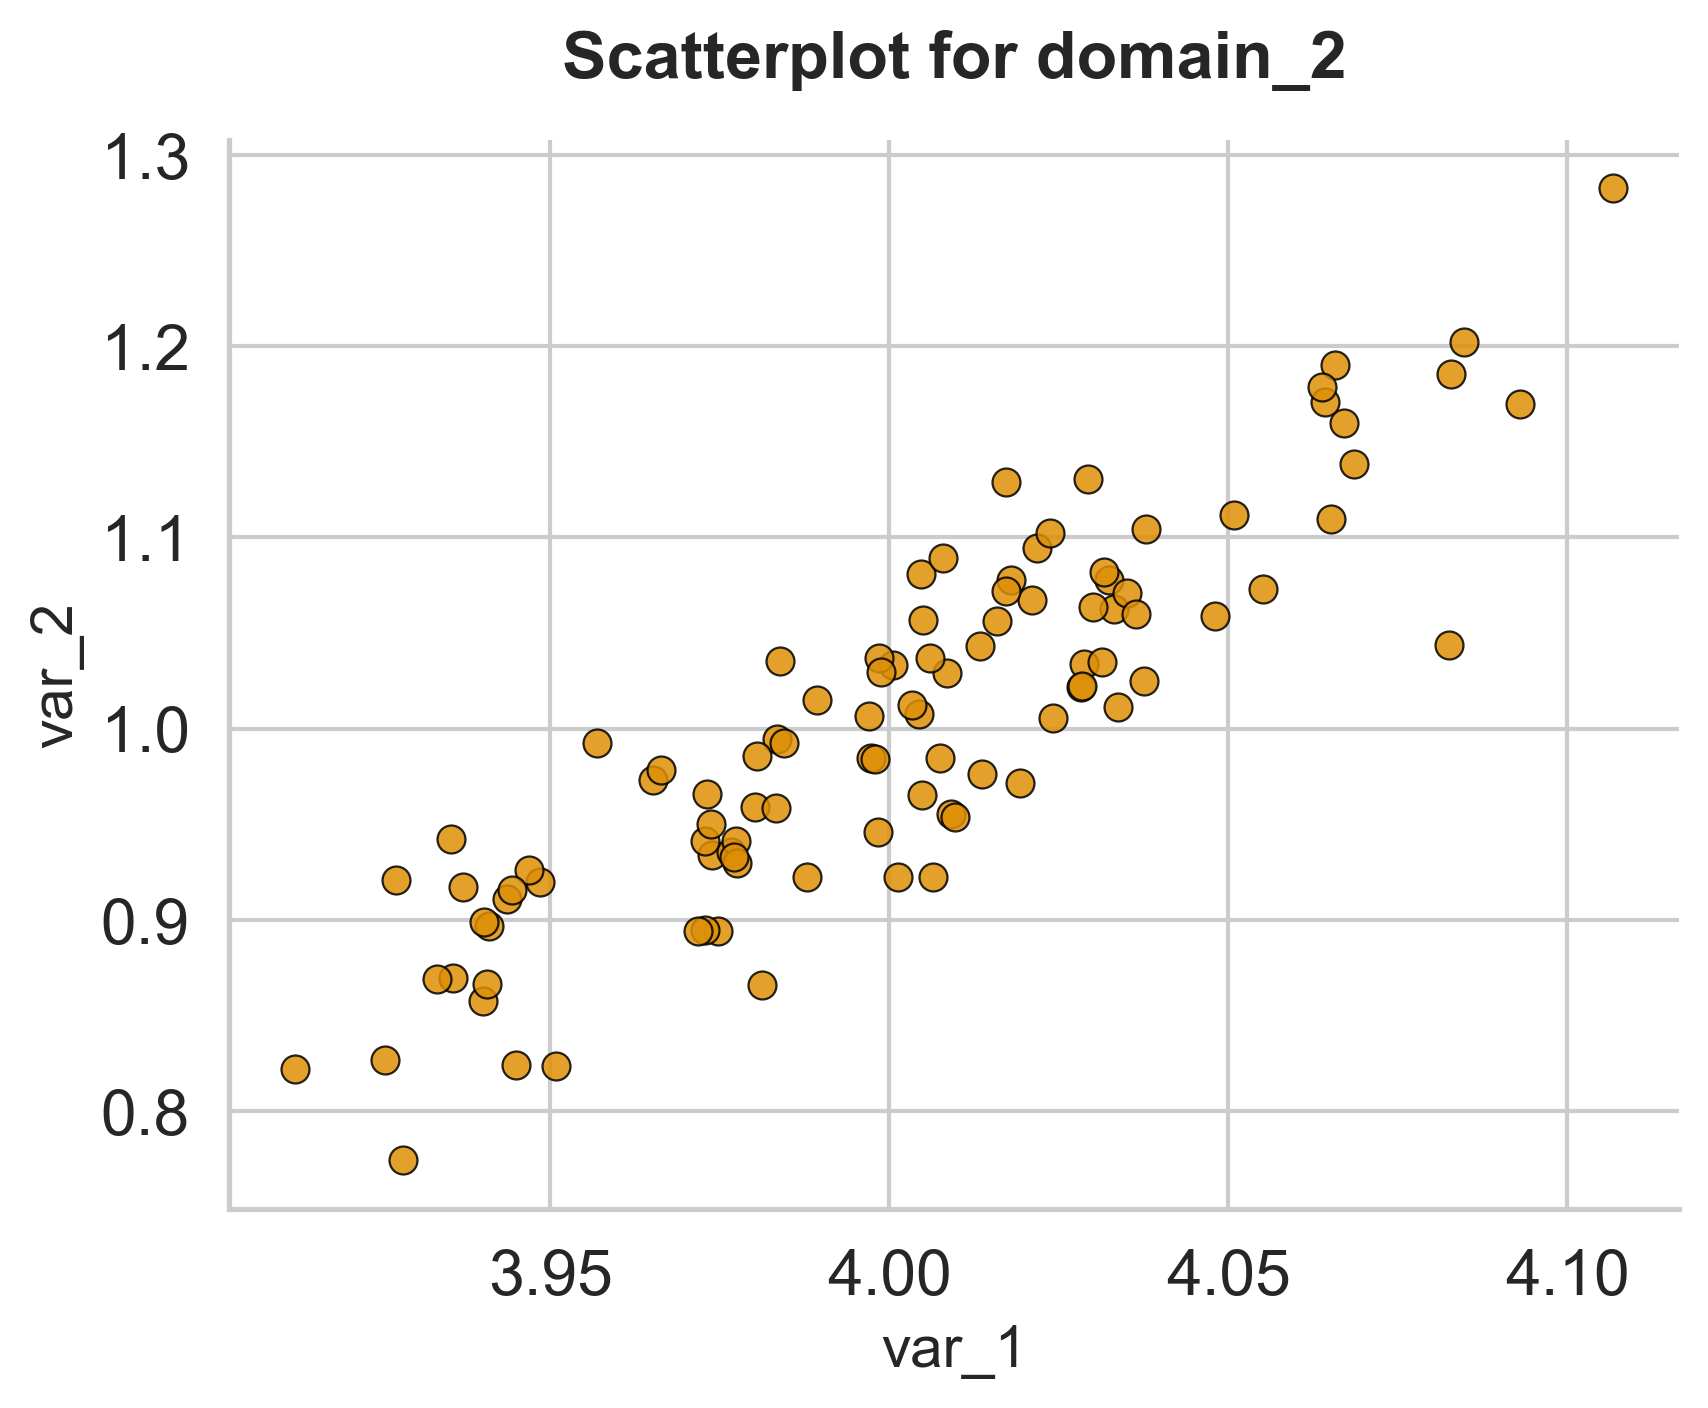

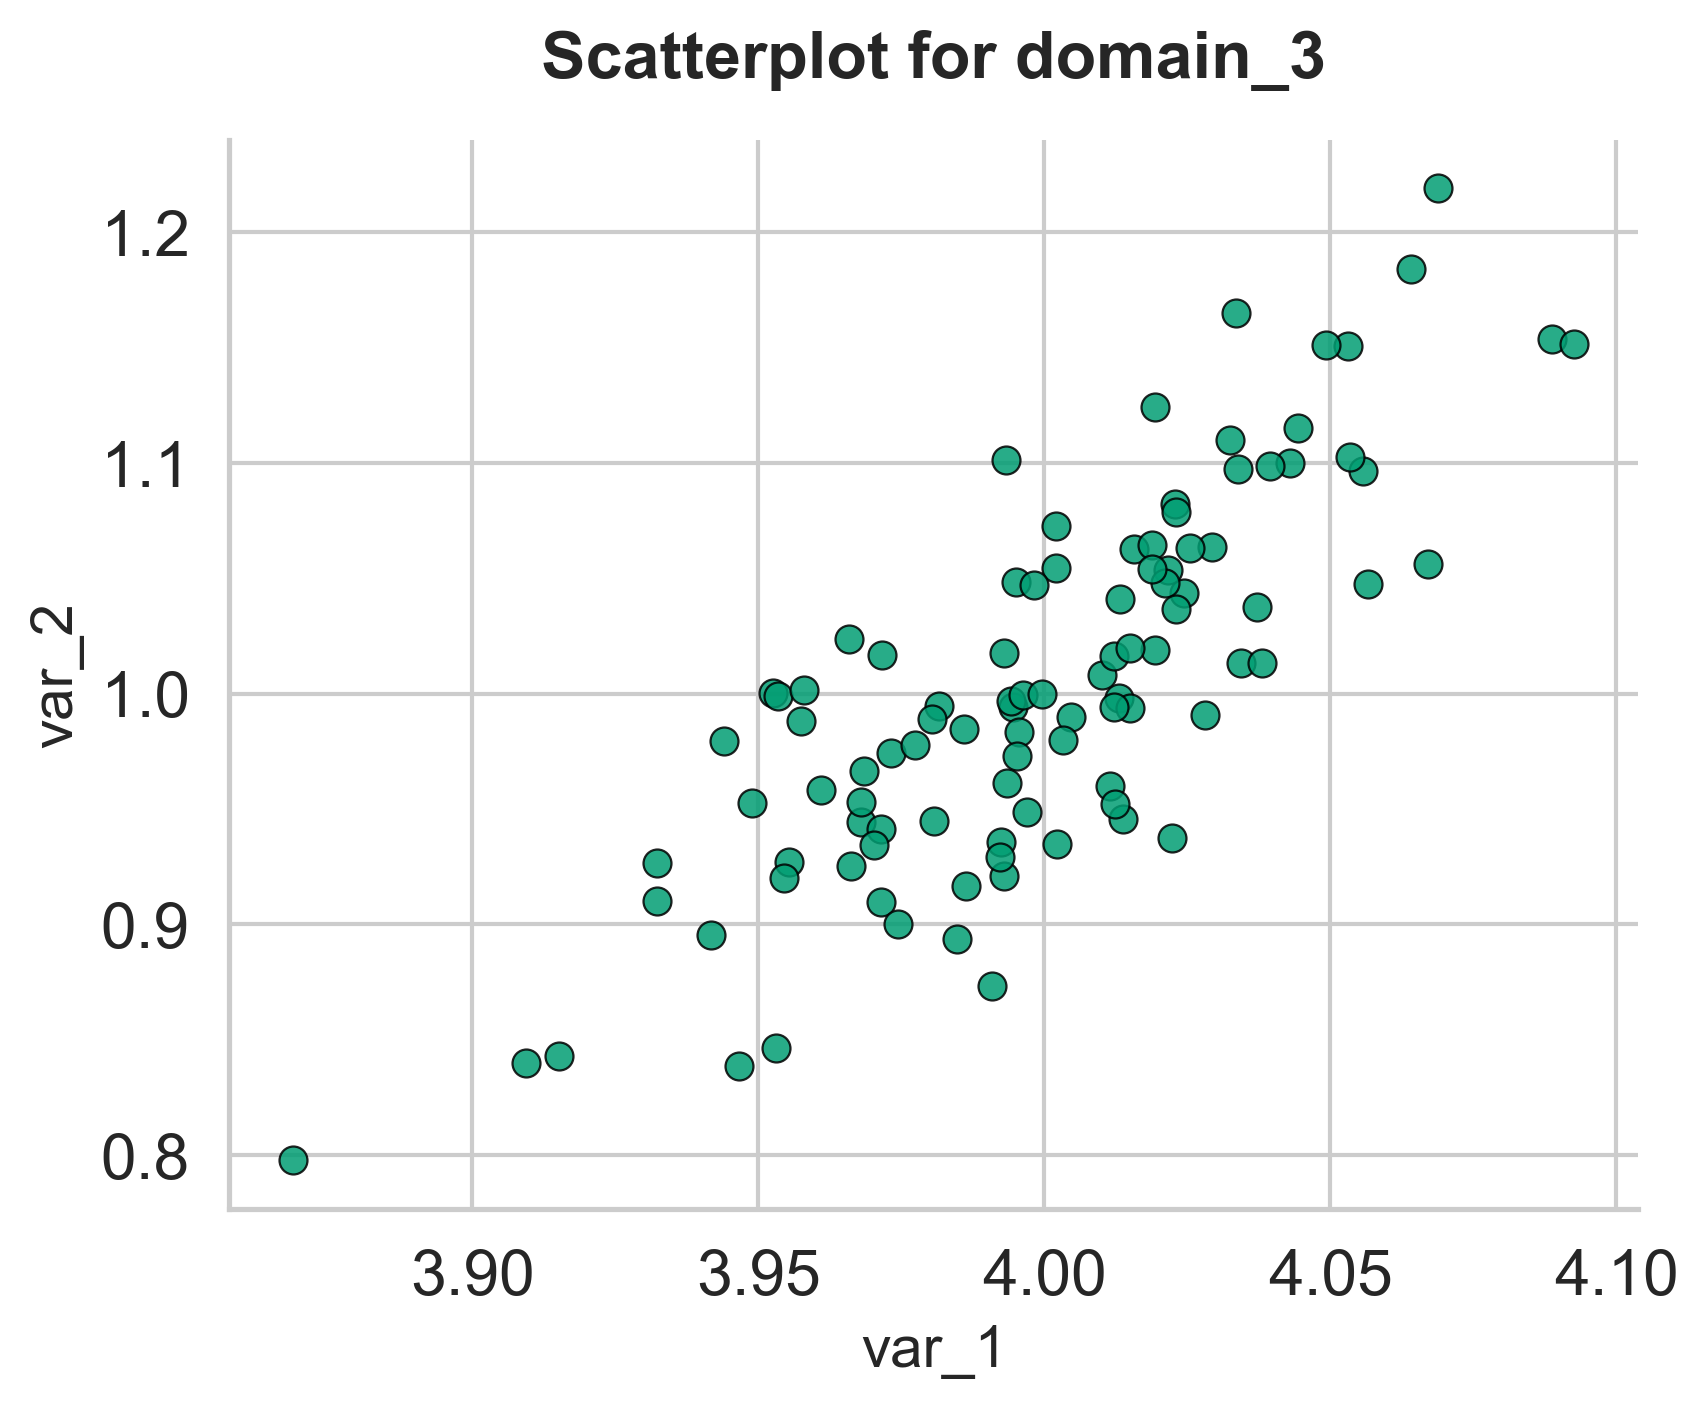

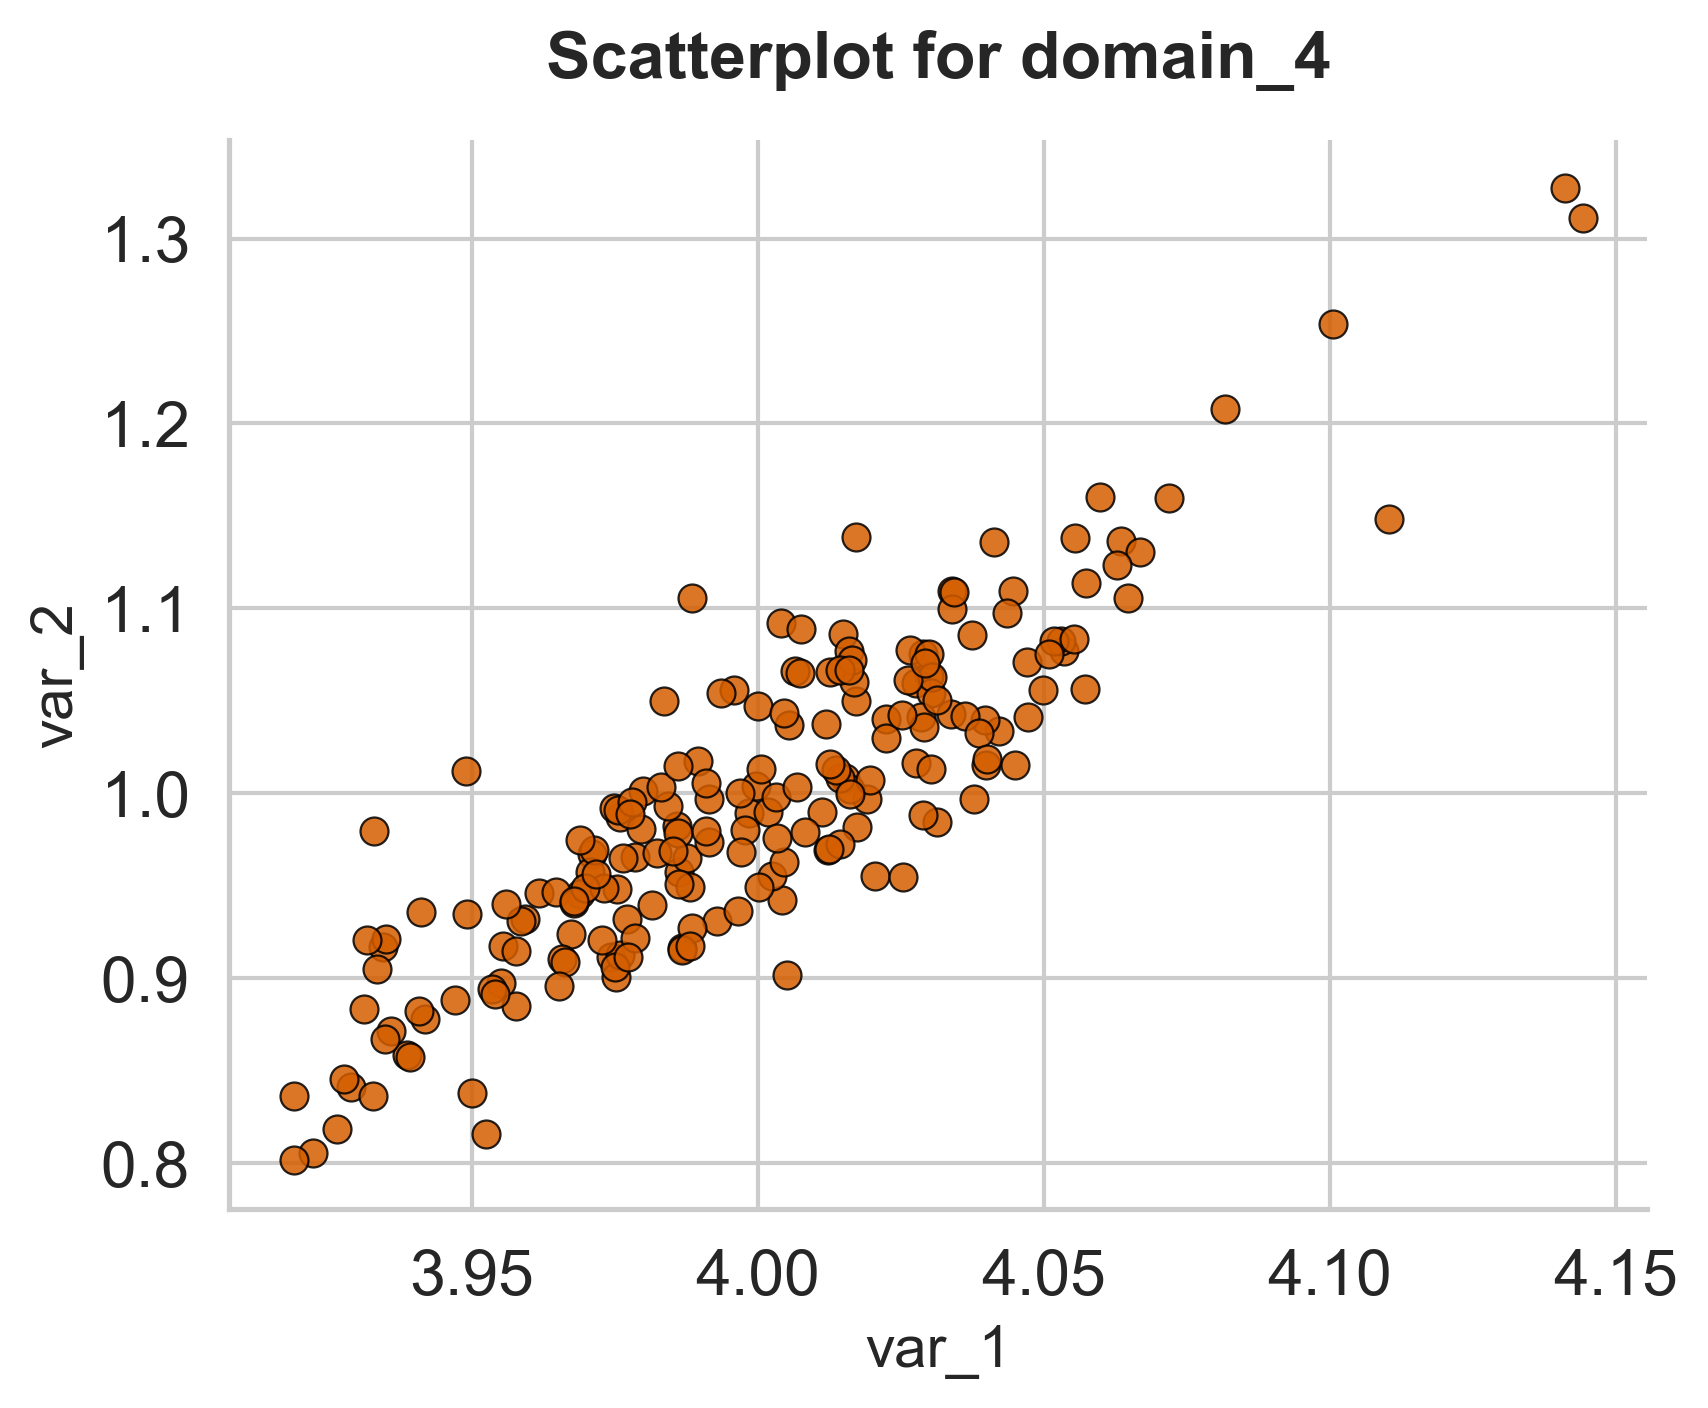

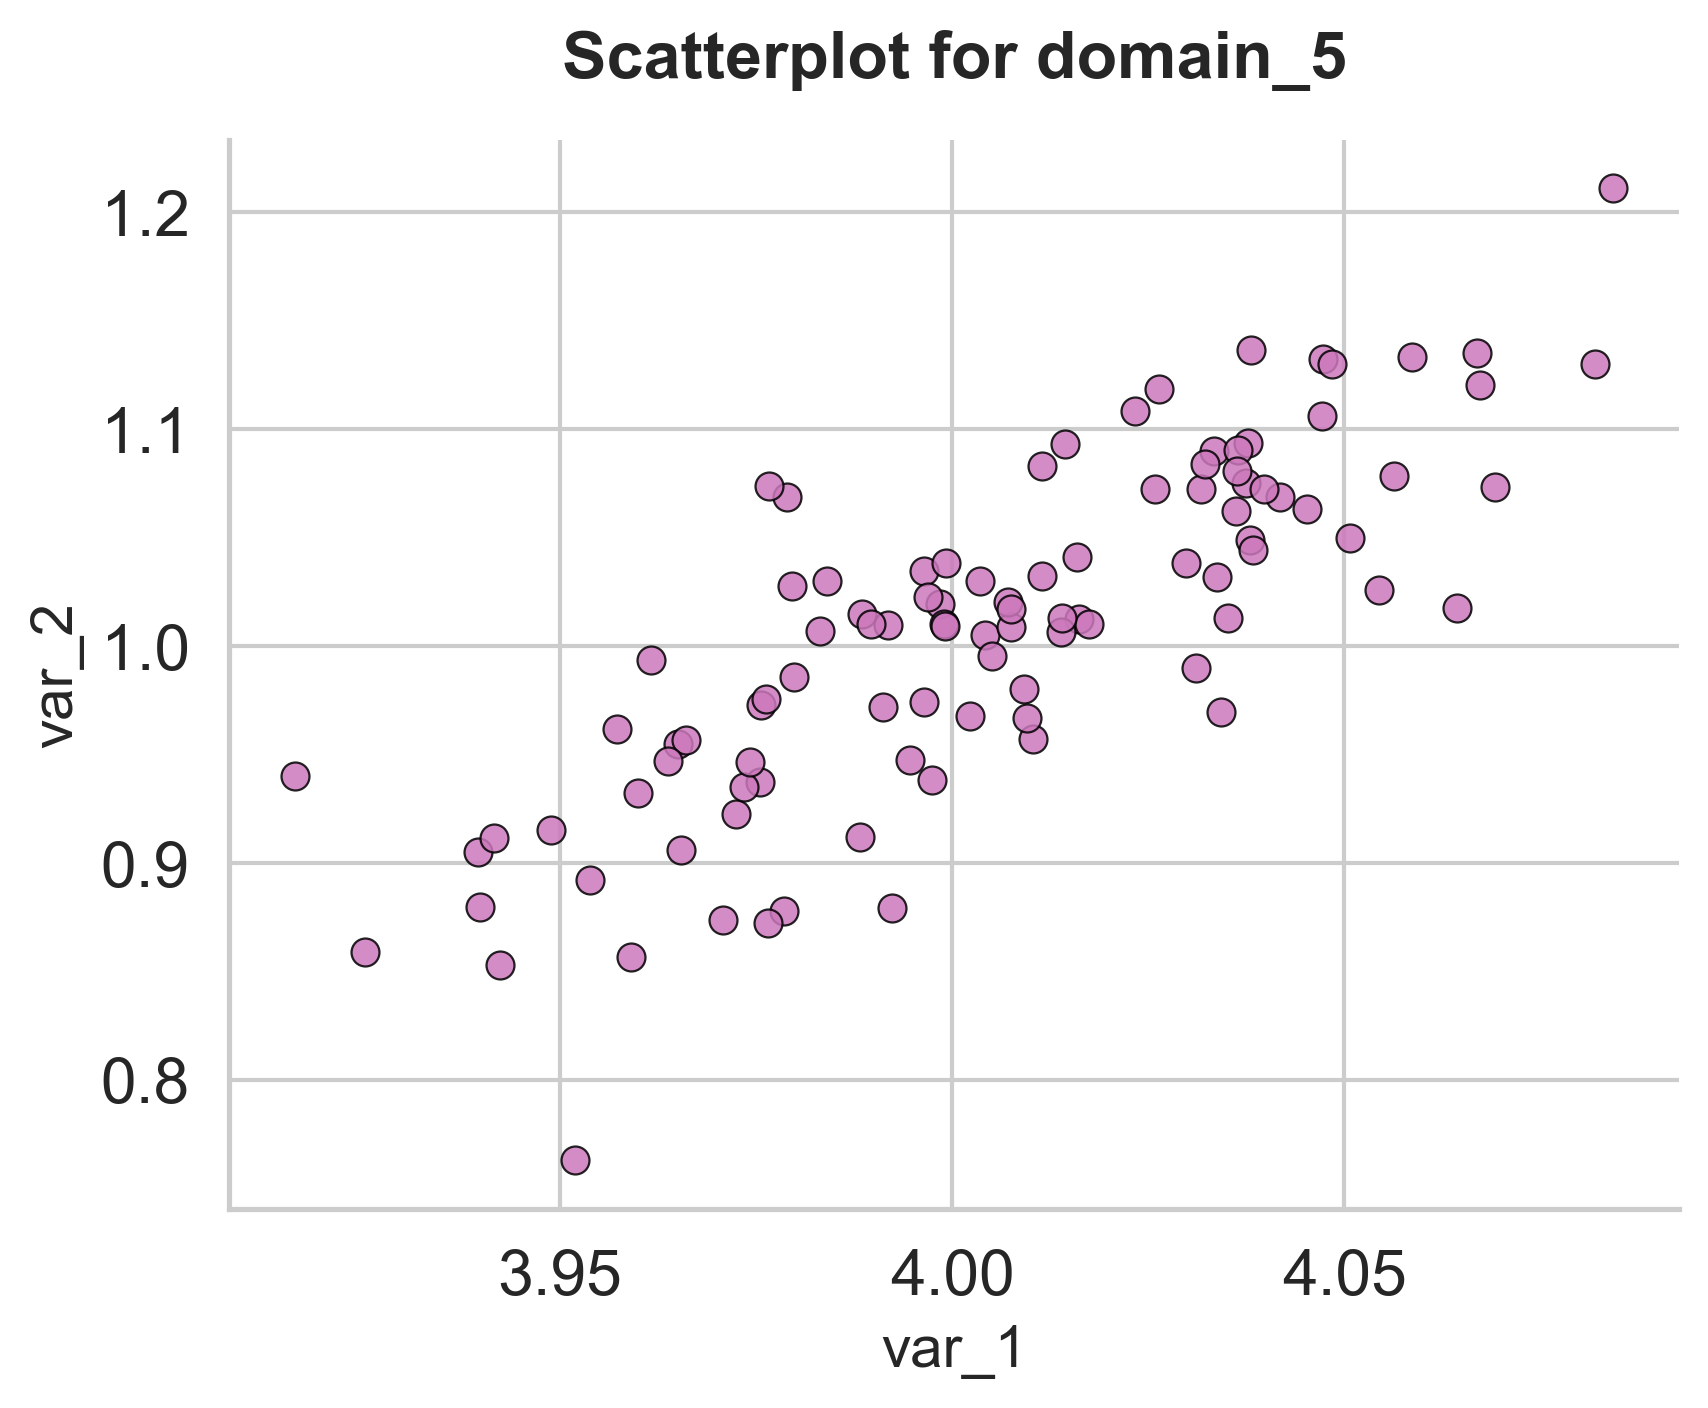

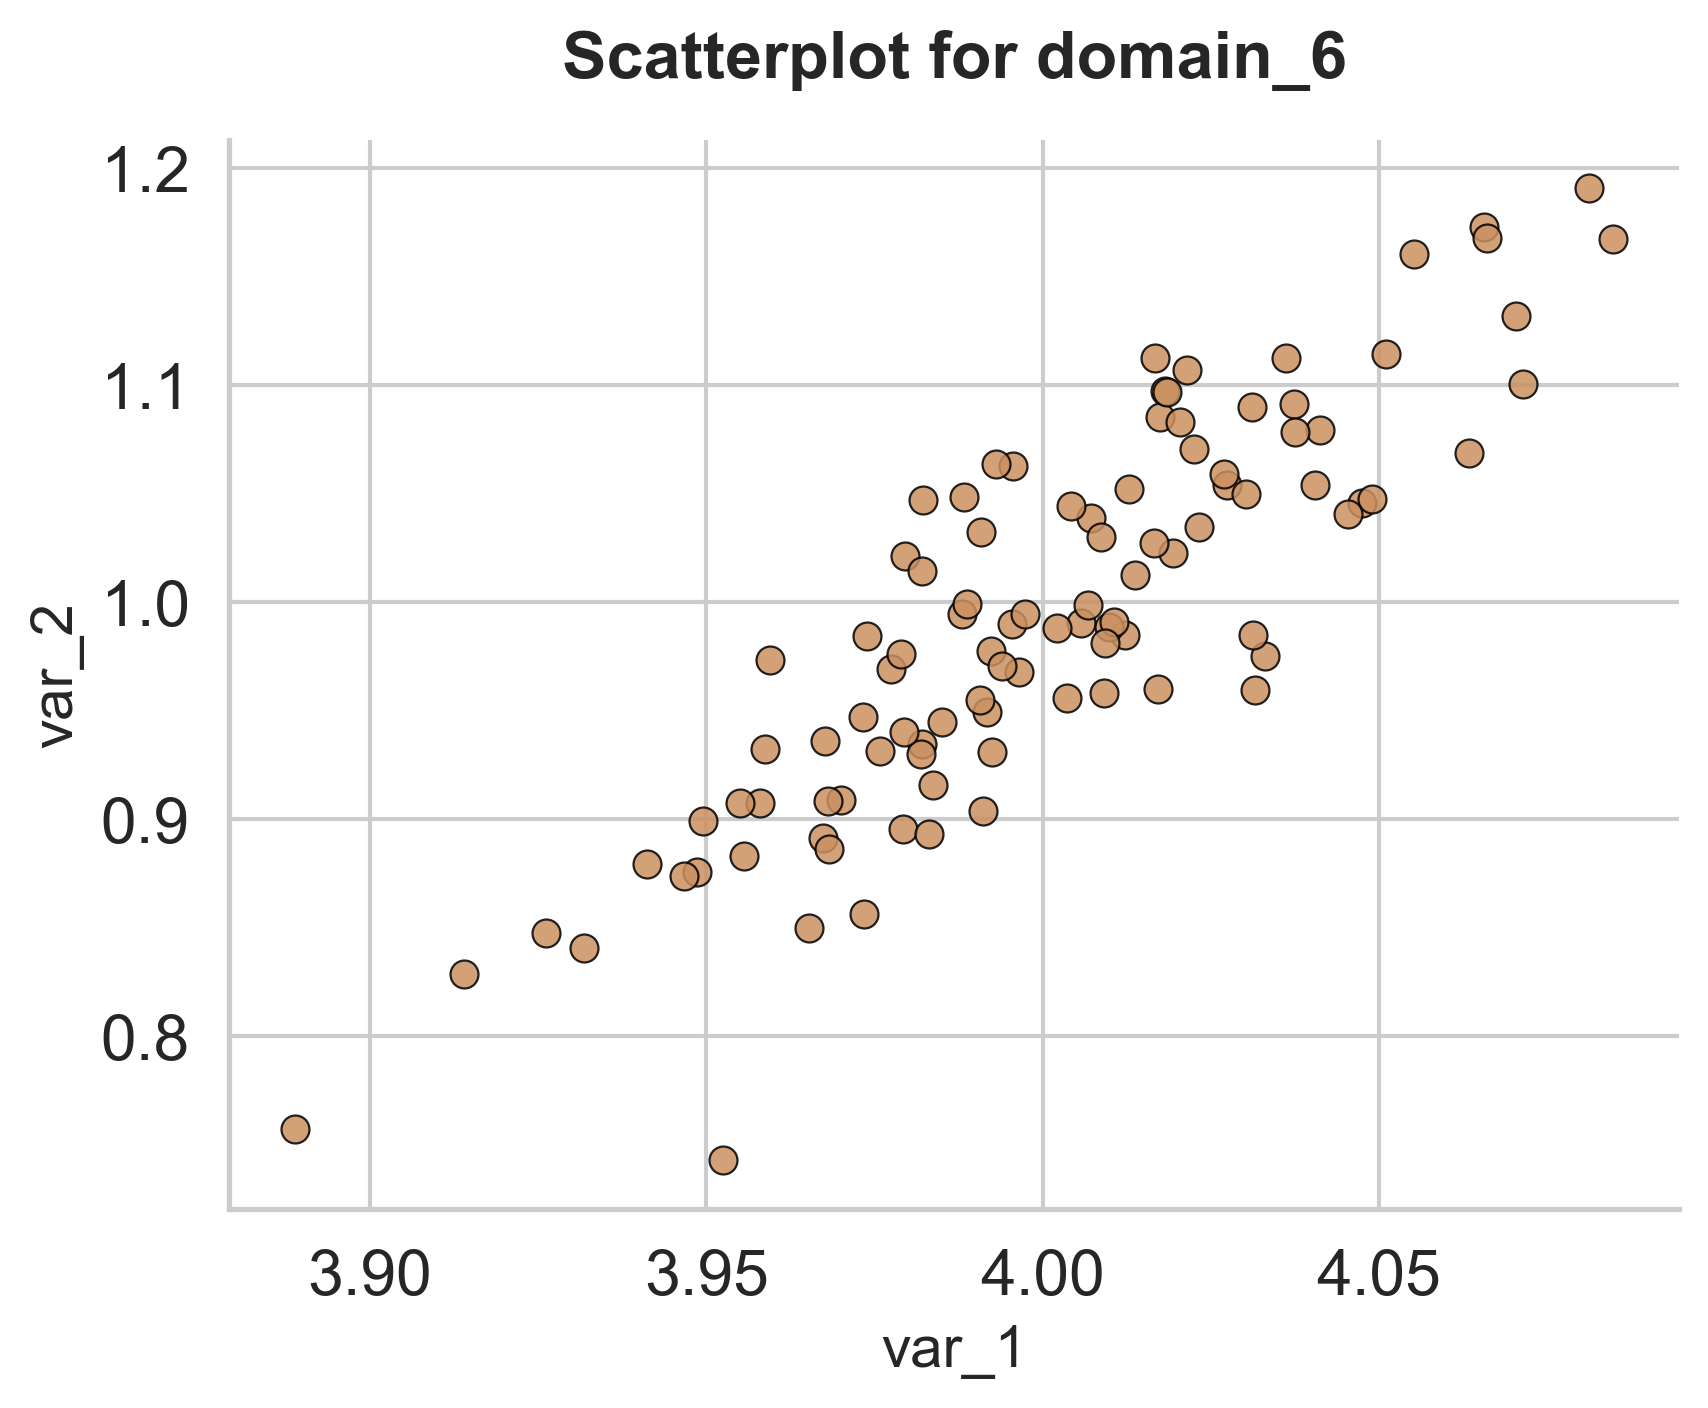

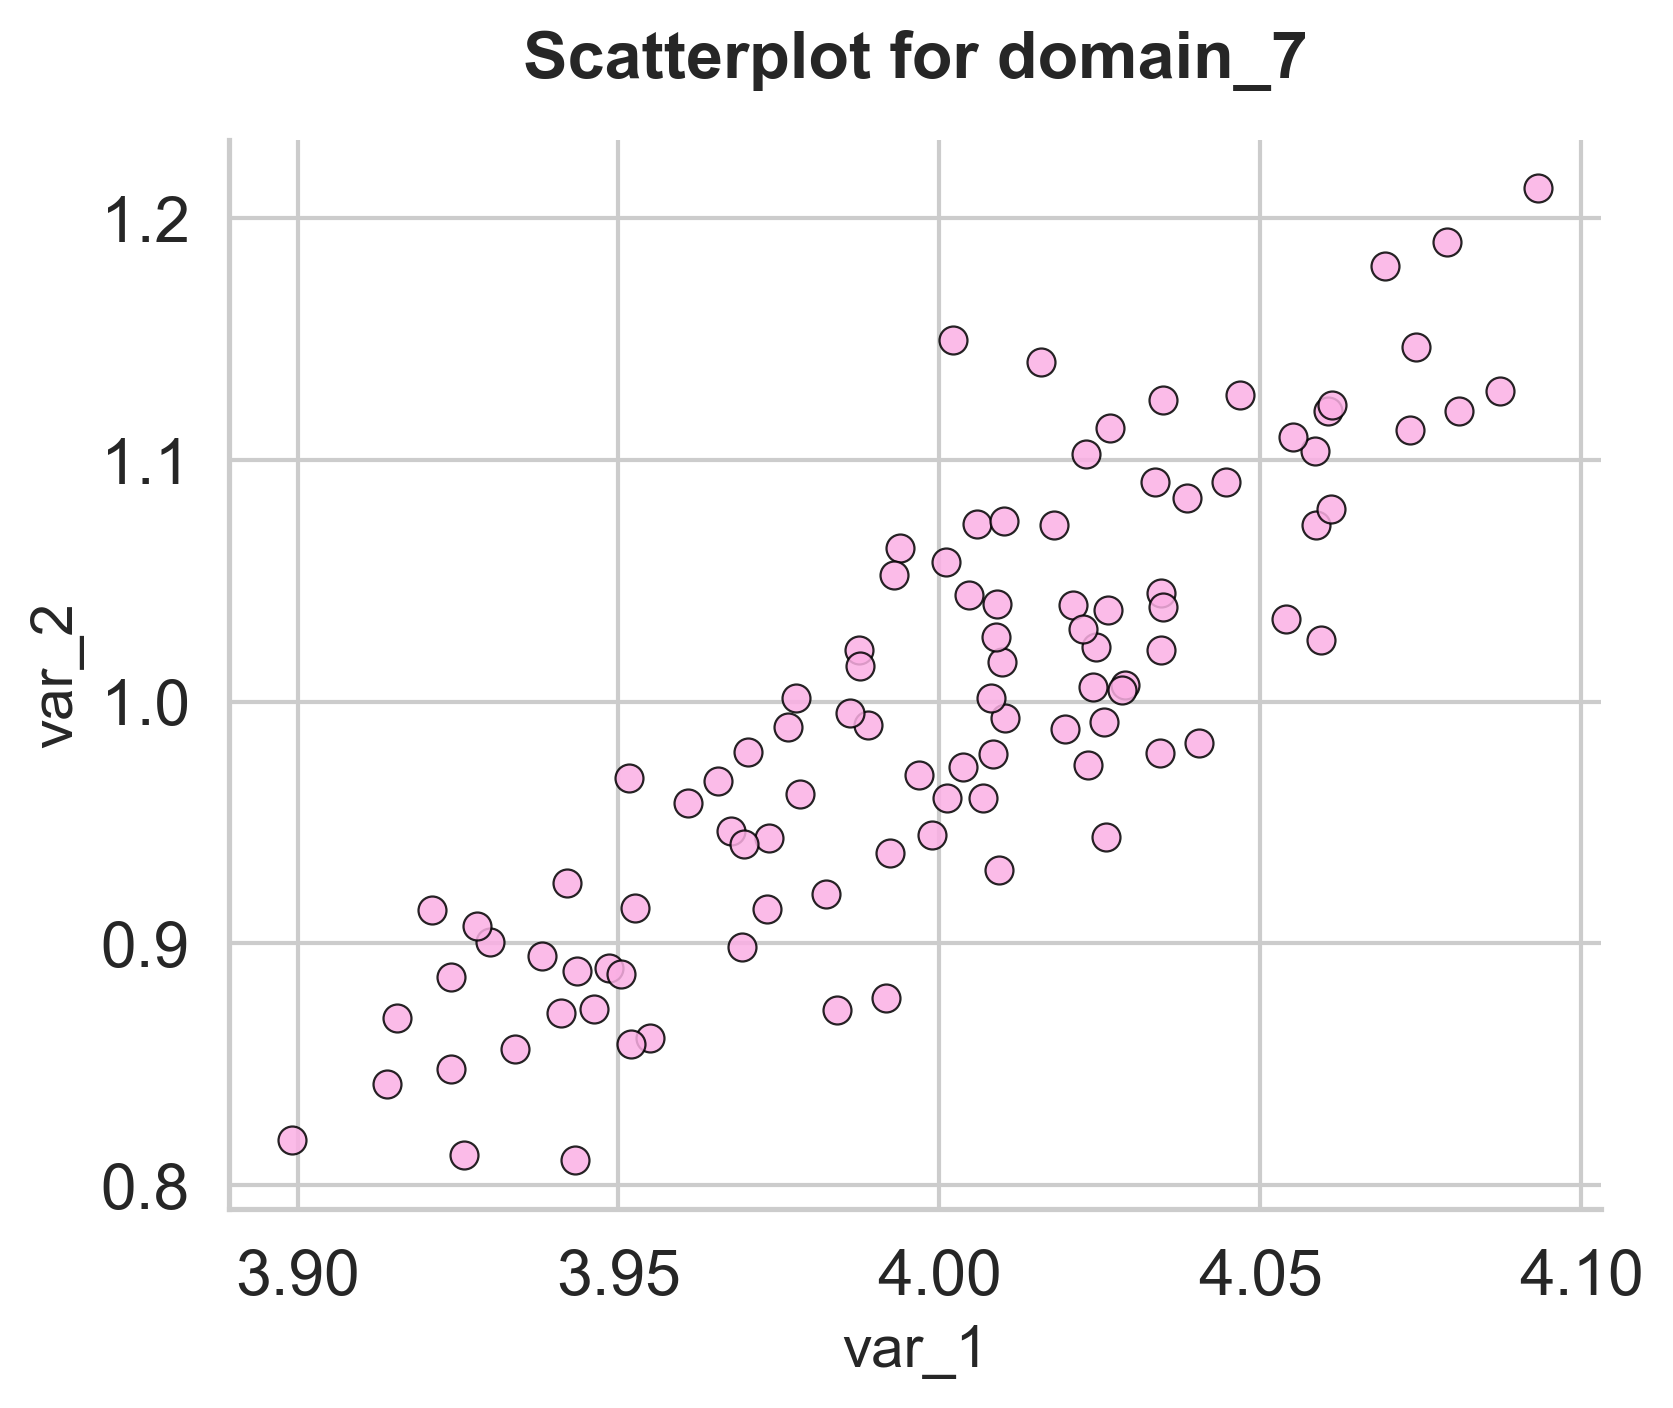

In [6]:
#Global style settings
sns.set_theme(style="whitegrid", font_scale=1.4)  # larger font
sns.set_palette("colorblind")  # colorblind-friendly
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 600
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# 1. Scatterplot with no hue
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_with_tags, x="var_1", y="var_2",
    color="black", s=40, alpha=0.7, edgecolor=None
)
plt.title("All data (no hue)", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

# 2. Scatterplot with hue = tag
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df_with_tags, x="var_1", y="var_2",
    hue="tag", s=40, alpha=0.8, edgecolor=None
)
plt.title("All data (colored by tag)", pad=15)
plt.legend(
    title="Tag", bbox_to_anchor=(1.02, 1), loc='upper left',
    borderaxespad=0, frameon=False
)
sns.despine()
plt.tight_layout()
plt.show()

# 3. One scatterplot per tag
tag_names = np.sort(df_with_tags["tag"].unique())
palette = sns.color_palette("colorblind", len(tag_names))

for i, tag in enumerate(tag_names):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_with_tags[df_with_tags["tag"] == tag],
        x="var_1", y="var_2",
        color=palette[i], s=45, alpha=0.85, edgecolor="black"
    )
    plt.title(f"Scatterplot for {tag}", pad=15)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [7]:
population = simulation_results["population"]
estimates = simulation_results["estimates"]

In [8]:
# ====================================================
# 1. True population value
# ====================================================
Y_true = np.sum(population["y"])

# ====================================================
# 2. Single-run estimates (for diagnostics)
# ====================================================
Y_SM = estimates['Y_SM']
Y_PML = estimates['Y_PML']

# Absolute Relative Error
ae_sm = np.abs(Y_SM - Y_true) / np.abs(Y_true)
ae_pml = np.abs(Y_PML - Y_true) / np.abs(Y_true)

# Log Relative Error
re_sm = np.log10(Y_SM / np.abs(Y_true))
re_pml = np.log10(Y_PML / np.abs(Y_true))

print("Single-run diagnostics")
print(f"  Abs. Rel. Error (SM):  {ae_sm:.4f}")
print(f"  Abs. Rel. Error (PML): {ae_pml:.4f}")
print(f"  Log Rel. Error (SM):   {re_sm:.4f}")
print(f"  Log Rel. Error (PML):  {re_pml:.4f}")
print("="*60)

# ====================================================
# 3. Multiple runs for empirical evaluation
# ====================================================
Nruns = 30
simulation = Simulation(reproduce=False)

YSM, YPML = [], []

for _ in range(Nruns):
    sim_res = simulation.run_pipeline()
    YSM.append(sim_res["estimates"]["Y_SM"])
    YPML.append(sim_res["estimates"]["Y_PML"])

YSM = np.array(YSM)
YPML = np.array(YPML)

# ====================================================
# 4. Helper: compute bias, variance, mse, and CIs
# ====================================================
def summarize_estimator(Y_est, Y_true, name):
    bias = np.mean(Y_est - Y_true)
    var  = np.var(Y_est, ddof=1)
    mse  = np.mean((Y_est - Y_true) ** 2)

    ci_bias = bootstrap((Y_est - Y_true,), np.mean).confidence_interval
    ci_var  = bootstrap((Y_est,), np.var).confidence_interval
    ci_mse  = bootstrap(((Y_est - Y_true)**2,), np.mean).confidence_interval

    return {
        "Estimator": name,
        "Bias (mean)": bias,
        "Bias CI": f"[{ci_bias.low:.3f}, {ci_bias.high:.3f}]",
        "Variance (mean)": var,
        "Variance CI": f"[{ci_var.low:.3f}, {ci_var.high:.3f}]",
        "MSE (mean)": mse,
        "MSE CI": f"[{ci_mse.low:.3f}, {ci_mse.high:.3f}]"
    }

results = [
    summarize_estimator(YSM, Y_true, "SM"),
    summarize_estimator(YPML, Y_true, "PML")
]

df_results = pd.DataFrame(results)

# ====================================================
# 5. Professional summary table
# ====================================================
print("\nSimulation Study Summary (Nruns = {})".format(Nruns))
print("="*80)
print(df_results.to_string(index=False))

Single-run diagnostics
  Abs. Rel. Error (SM):  0.0112
  Abs. Rel. Error (PML): 0.0326
  Log Rel. Error (SM):   0.0048
  Log Rel. Error (PML):  -0.0144

Simulation Study Summary (Nruns = 30)
Estimator  Bias (mean)           Bias CI  Variance (mean)          Variance CI  MSE (mean)               MSE CI
       SM     8.448512 [-10.560, 23.941]      2386.613633 [1456.962, 3760.414] 2378.437201 [1612.053, 3582.977]
      PML     5.884769  [-9.515, 20.922]      1852.449127 [1305.772, 2512.433] 1825.331329 [1268.978, 2475.802]


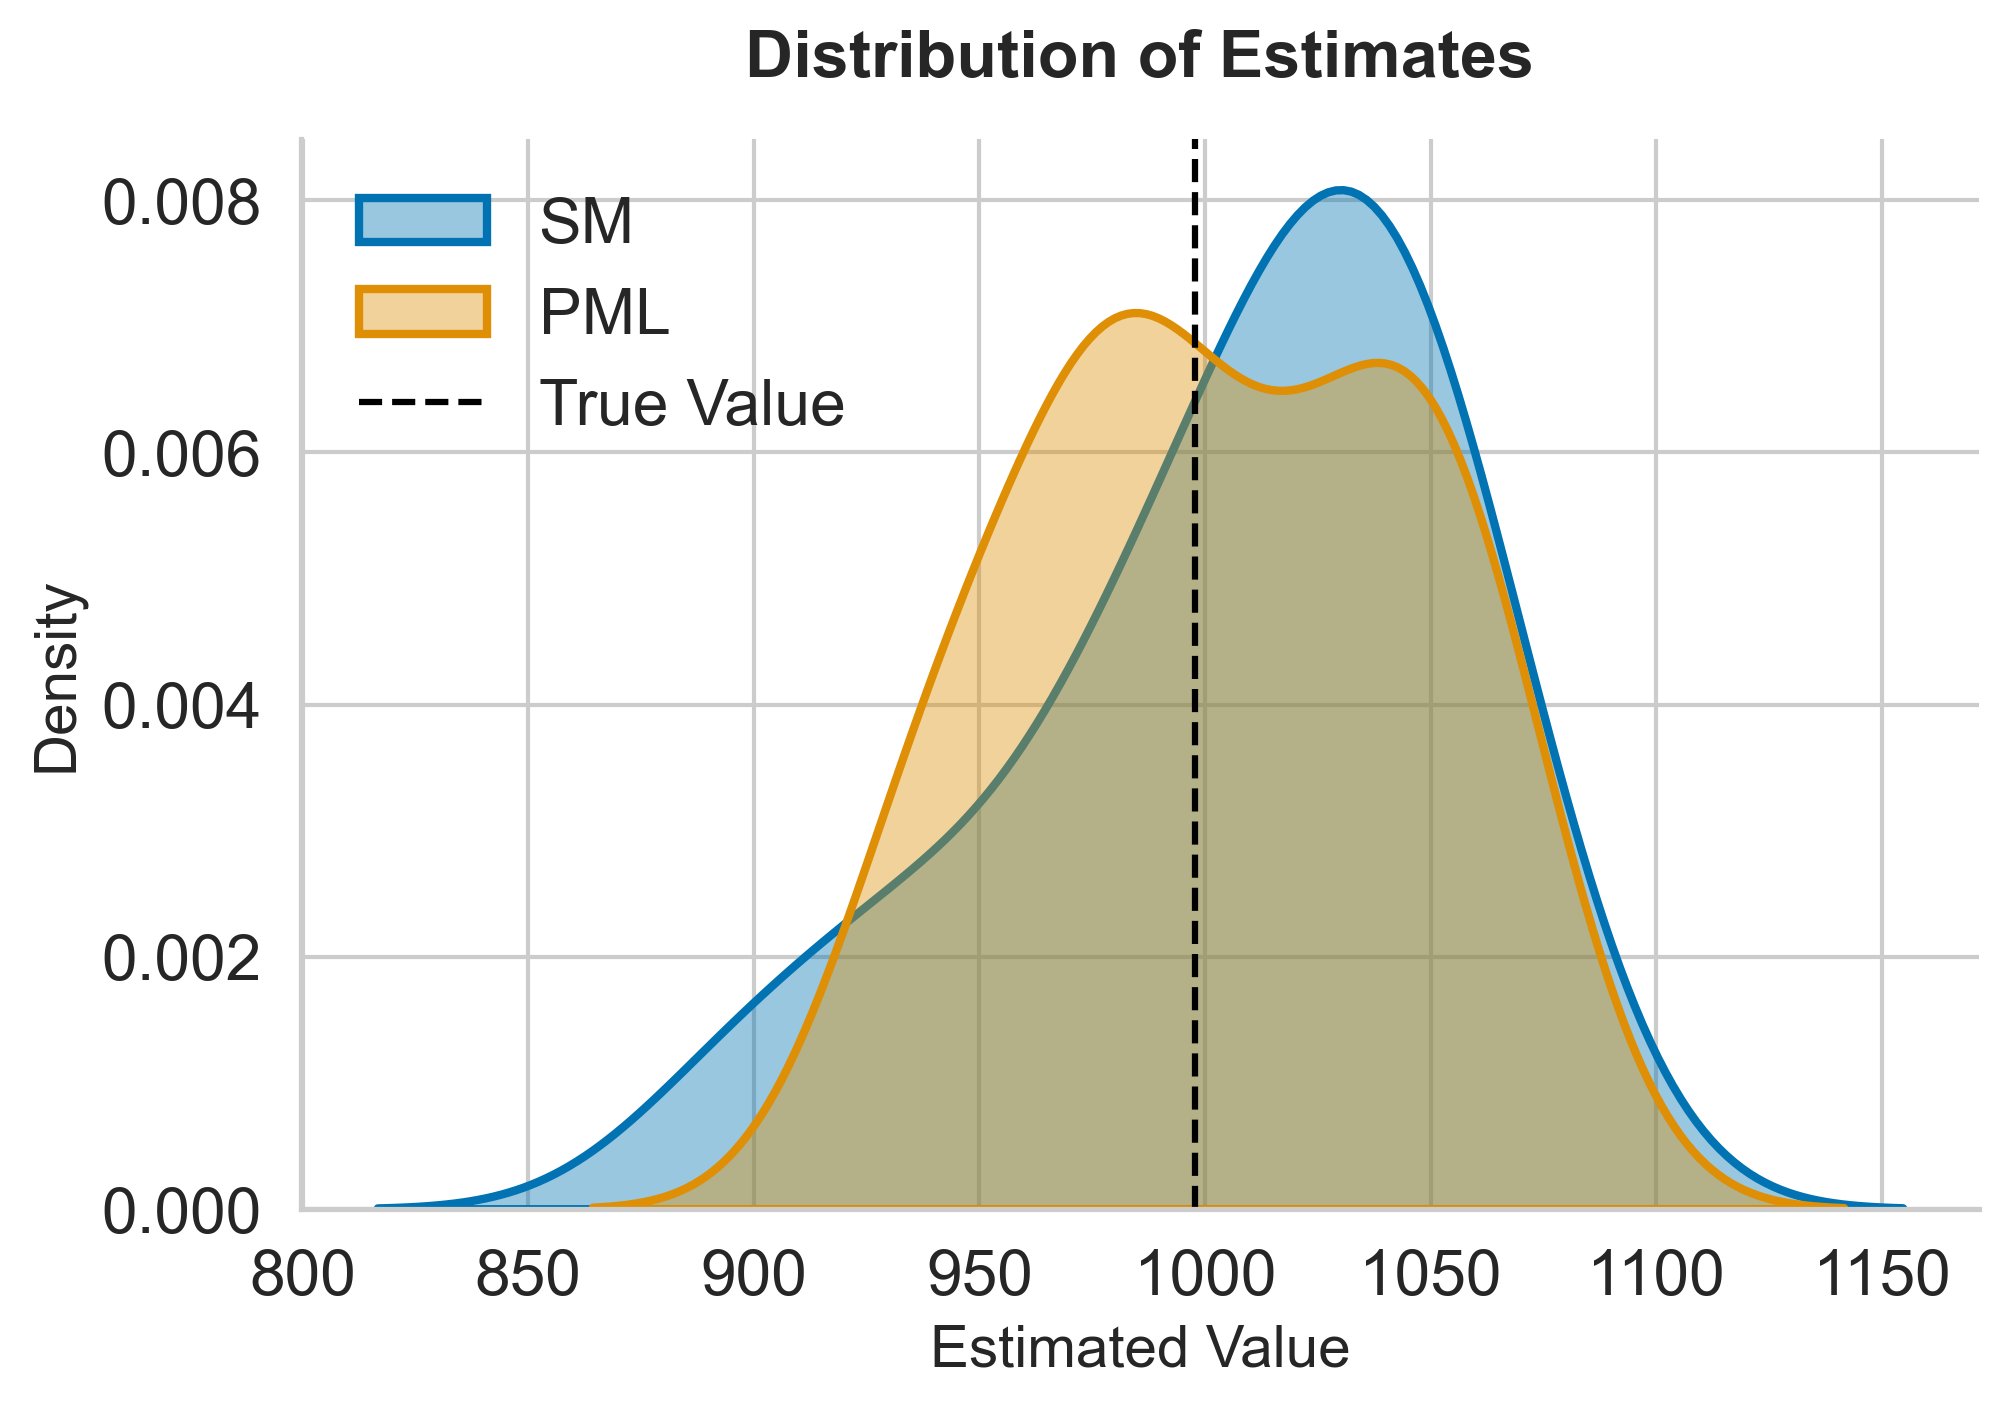

/var/folders/s9/2g4mtr3x4n197qnwspxrv3_00000gn/T/ipykernel_58866/1865449856.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bias_df, x="Estimator", y="Bias", palette="Set2", width=0.5, linewidth=1.2)


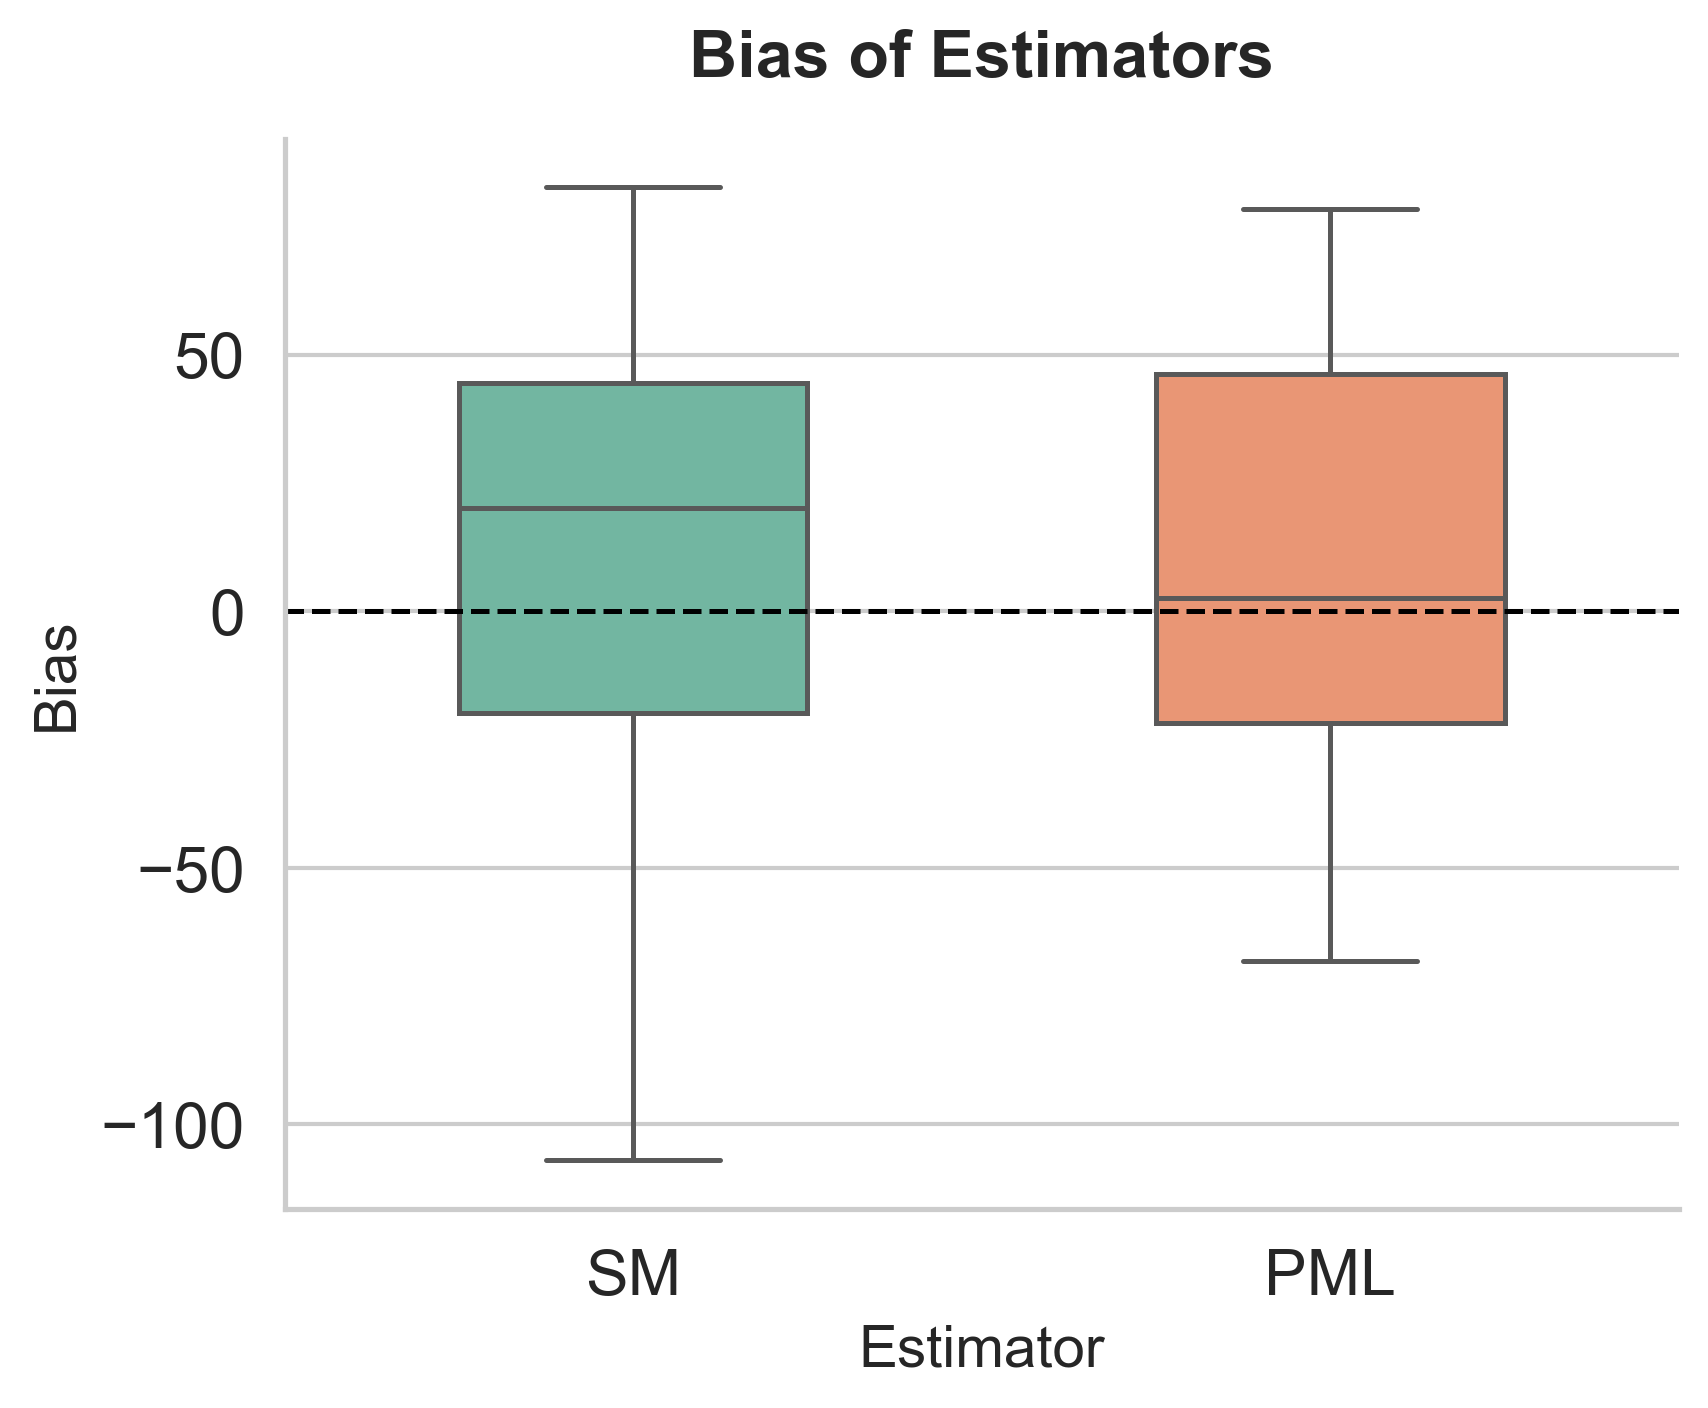

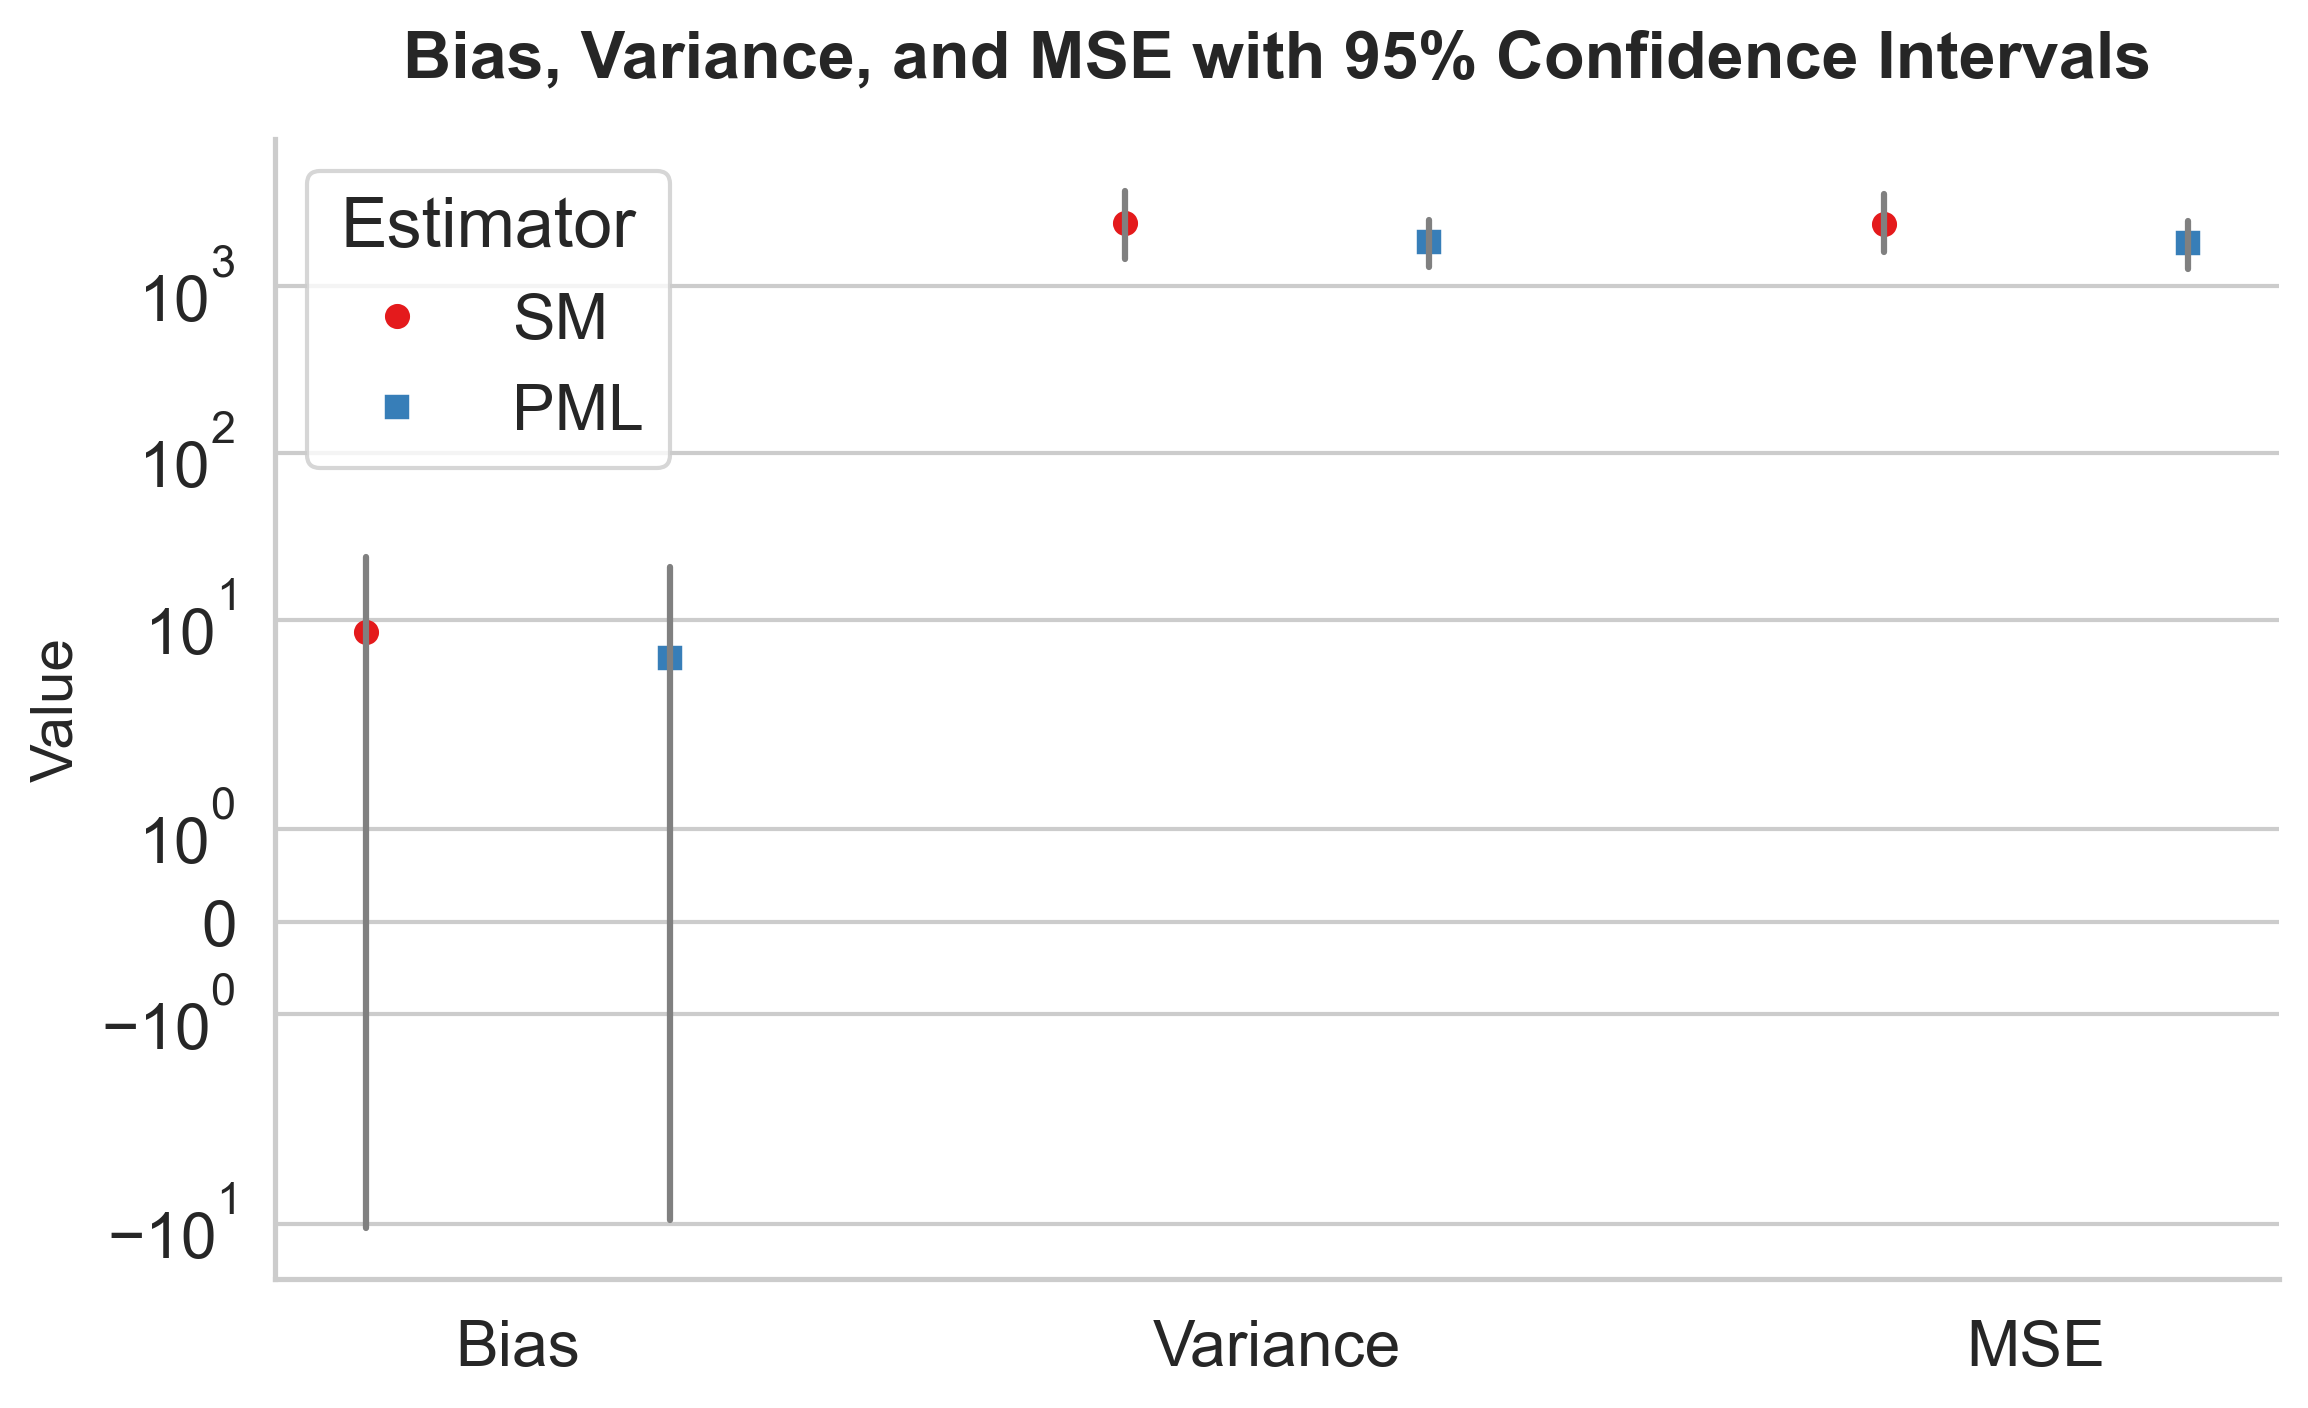

In [9]:
# Global style for publication
sns.set_theme(style="whitegrid", font_scale=1.4)
sns.set_palette("colorblind")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 600
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14

# 1. Distribution of estimates vs True value
plt.figure(figsize=(7, 5))
sns.kdeplot(YSM, label="SM", fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(YPML, label="PML", fill=True, alpha=0.4, linewidth=2)
plt.axvline(Y_true, color="black", linestyle="--", linewidth=1.5, label="True Value")
plt.title("Distribution of Estimates", pad=15)
plt.xlabel("Estimated Value")
plt.ylabel("Density")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

# 2. Boxplot of bias
bias_df = pd.DataFrame({
    "Bias": np.concatenate([YSM - Y_true, YPML - Y_true]),
    "Estimator": ["SM"] * len(YSM) + ["PML"] * len(YPML)
})

plt.figure(figsize=(6, 5))
sns.boxplot(data=bias_df, x="Estimator", y="Bias", palette="Set2", width=0.5, linewidth=1.2)
plt.axhline(0, color="black", linestyle="--", linewidth=1.2)
plt.title("Bias of Estimators", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

# 3. Error bar plot (Bias, Variance, MSE with 95% CI)
def parse_ci(ci_str):
    low, high = ci_str.strip("[]").split(",")
    return float(low), float(high)

plot_data = []
for _, row in df_results.iterrows():
    for metric in ["Bias", "Variance", "MSE"]:
        mean_val = row[f"{metric} (mean)"]
        low, high = parse_ci(row[f"{metric} CI"])
        plot_data.append({
            "Estimator": row["Estimator"],
            "Metric": metric,
            "Mean": mean_val,
            "CI_low": low,
            "CI_high": high
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(8, 5))
sns.pointplot(
    data=plot_df, x="Metric", y="Mean", hue="Estimator", 
    dodge=0.4, linestyle="None", palette="Set1", markers=["o", "s"], markersize=4, errorbar= None,
)

# Add error bars
for i, row in plot_df.iterrows():
    xpos = (
        {"Bias": 0, "Variance": 1, "MSE": 2}[row["Metric"]] +
        (-0.2 if row["Estimator"] == "SM" else 0.2)
    )
    plt.plot([xpos, xpos], [row["CI_low"], row["CI_high"]], 
             color="gray", linewidth=1.5, solid_capstyle="round")

plt.title("Bias, Variance, and MSE with 95% Confidence Intervals", pad=15)
plt.ylabel("Value")
plt.xlabel("")
plt.yscale("symlog")
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
#Stability of frame/domain reconstructions
estimates["Nhat_q"]/np.array([len(item) for item in population["frames"]])

#

array([1.        , 1.00157038, 0.99695681])

In [11]:
estimates["NPML_d"]/population["Nd"]

array([0.99222771, 0.93430259, 0.78347747, 0.79303503, 1.13171   ,
       1.17409055, 1.10812939])

ole


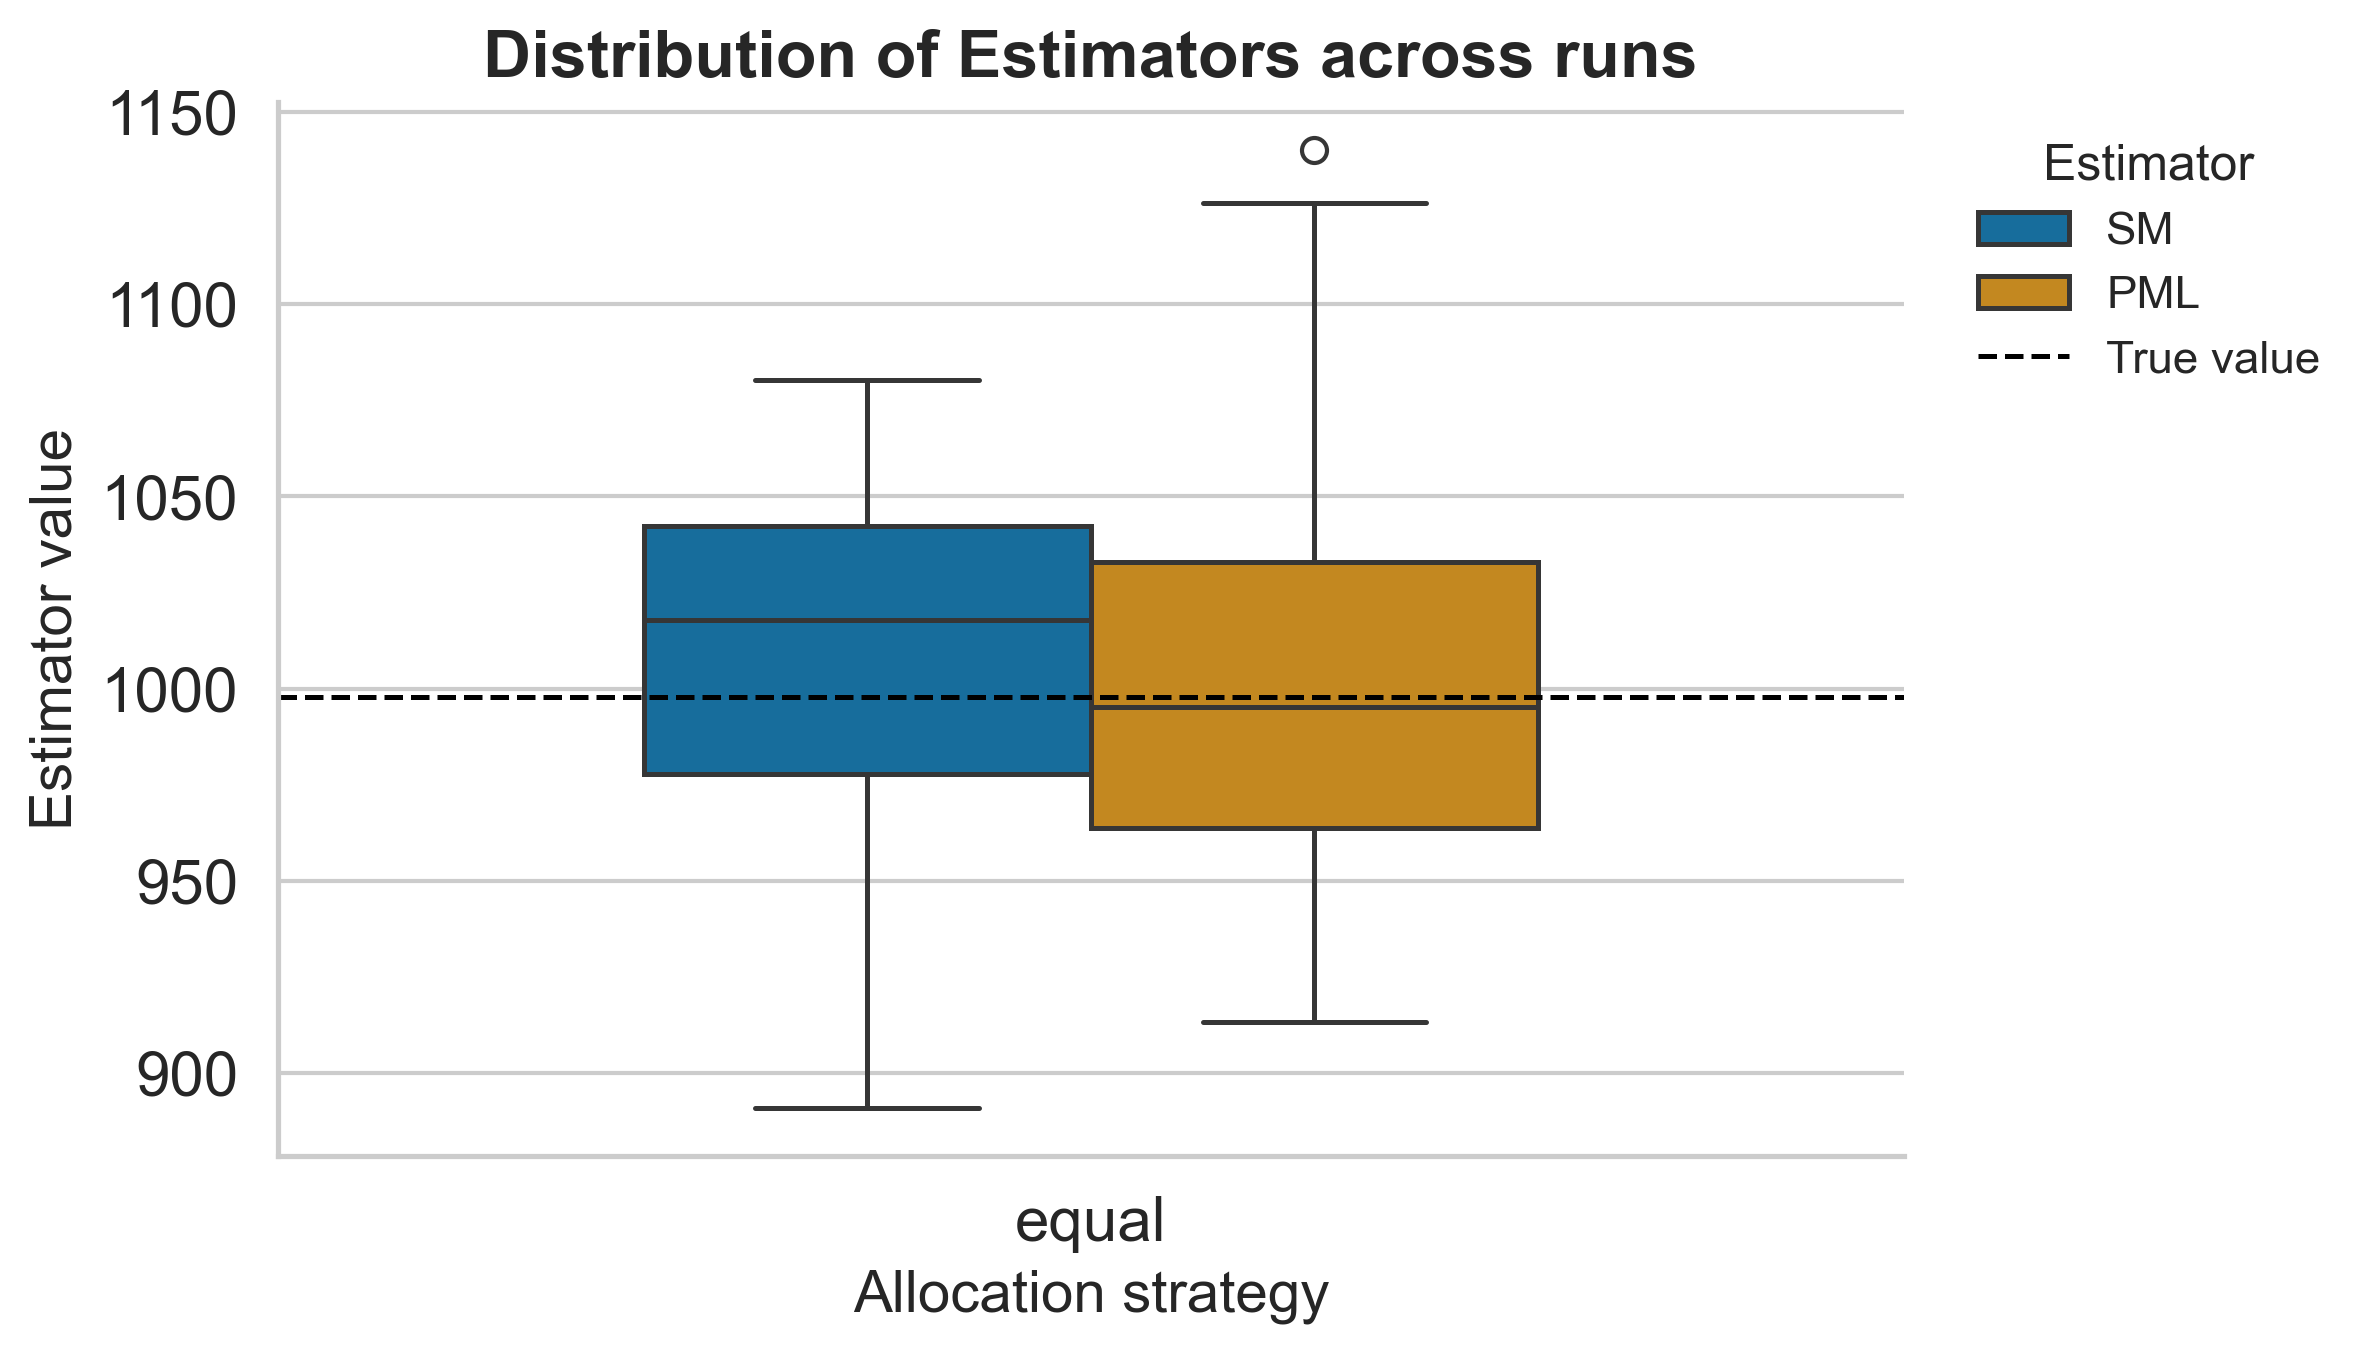

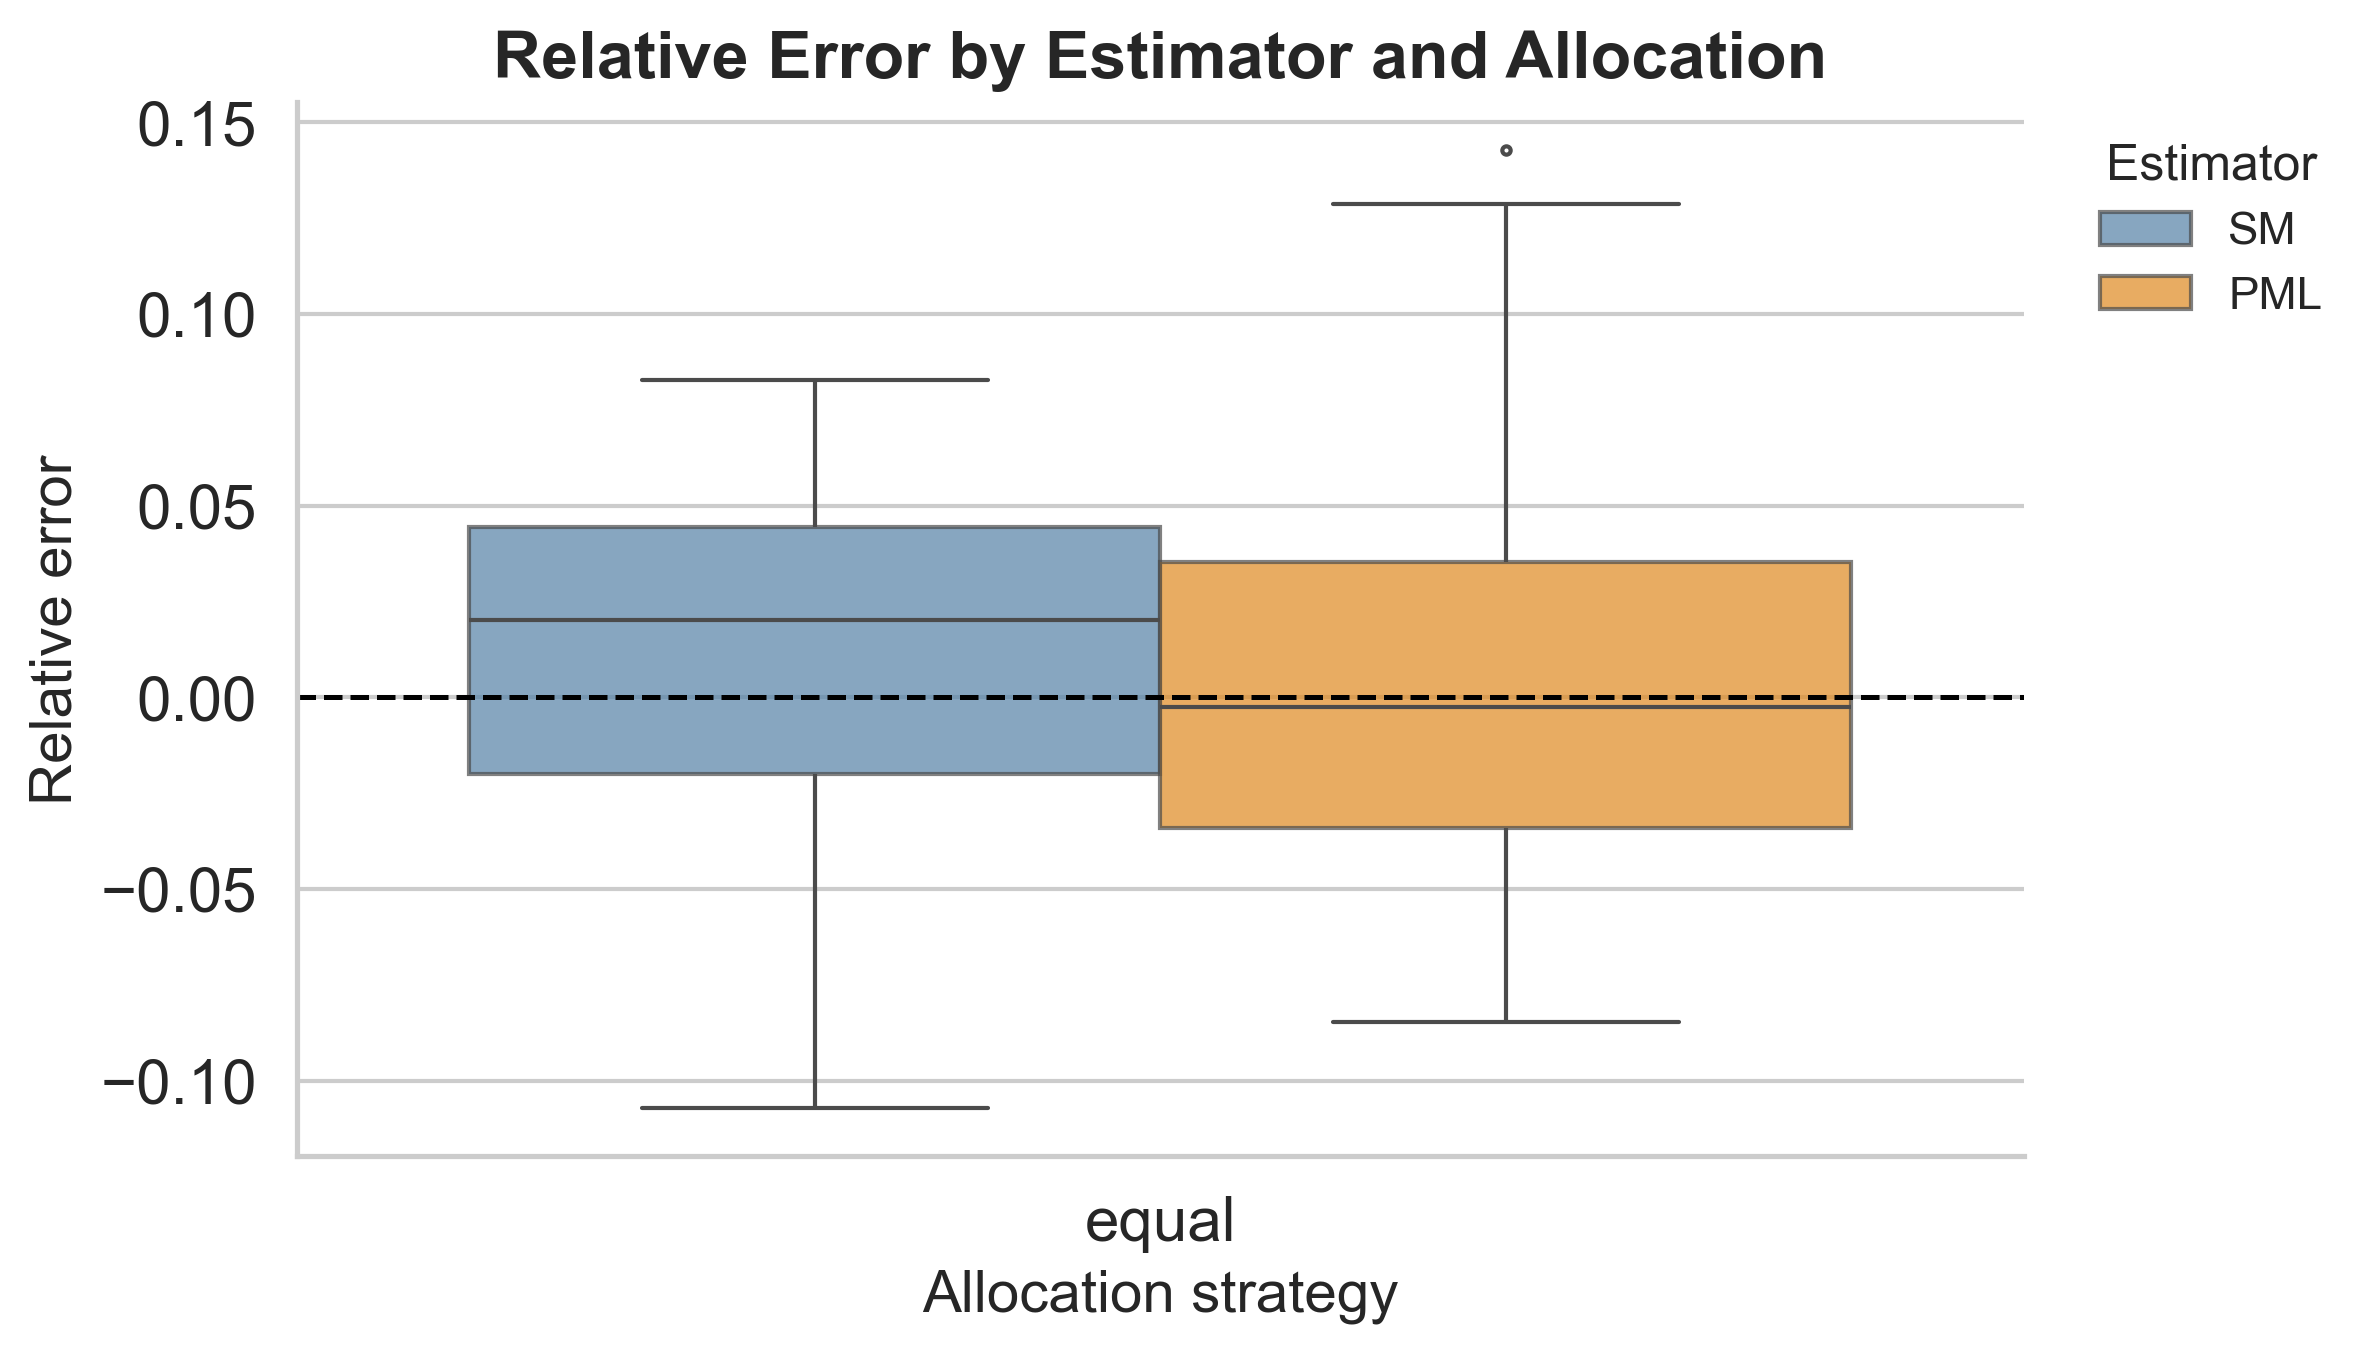

  allocation Estimator          MSE       CI_low      CI_high   n
0      equal       PML  3262.606416  1613.882393  5162.648467  30
1      equal        SM  2378.437201  1509.664008  3408.790226  30


/opt/anaconda3/envs/LMR_paper/lib/python3.10/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


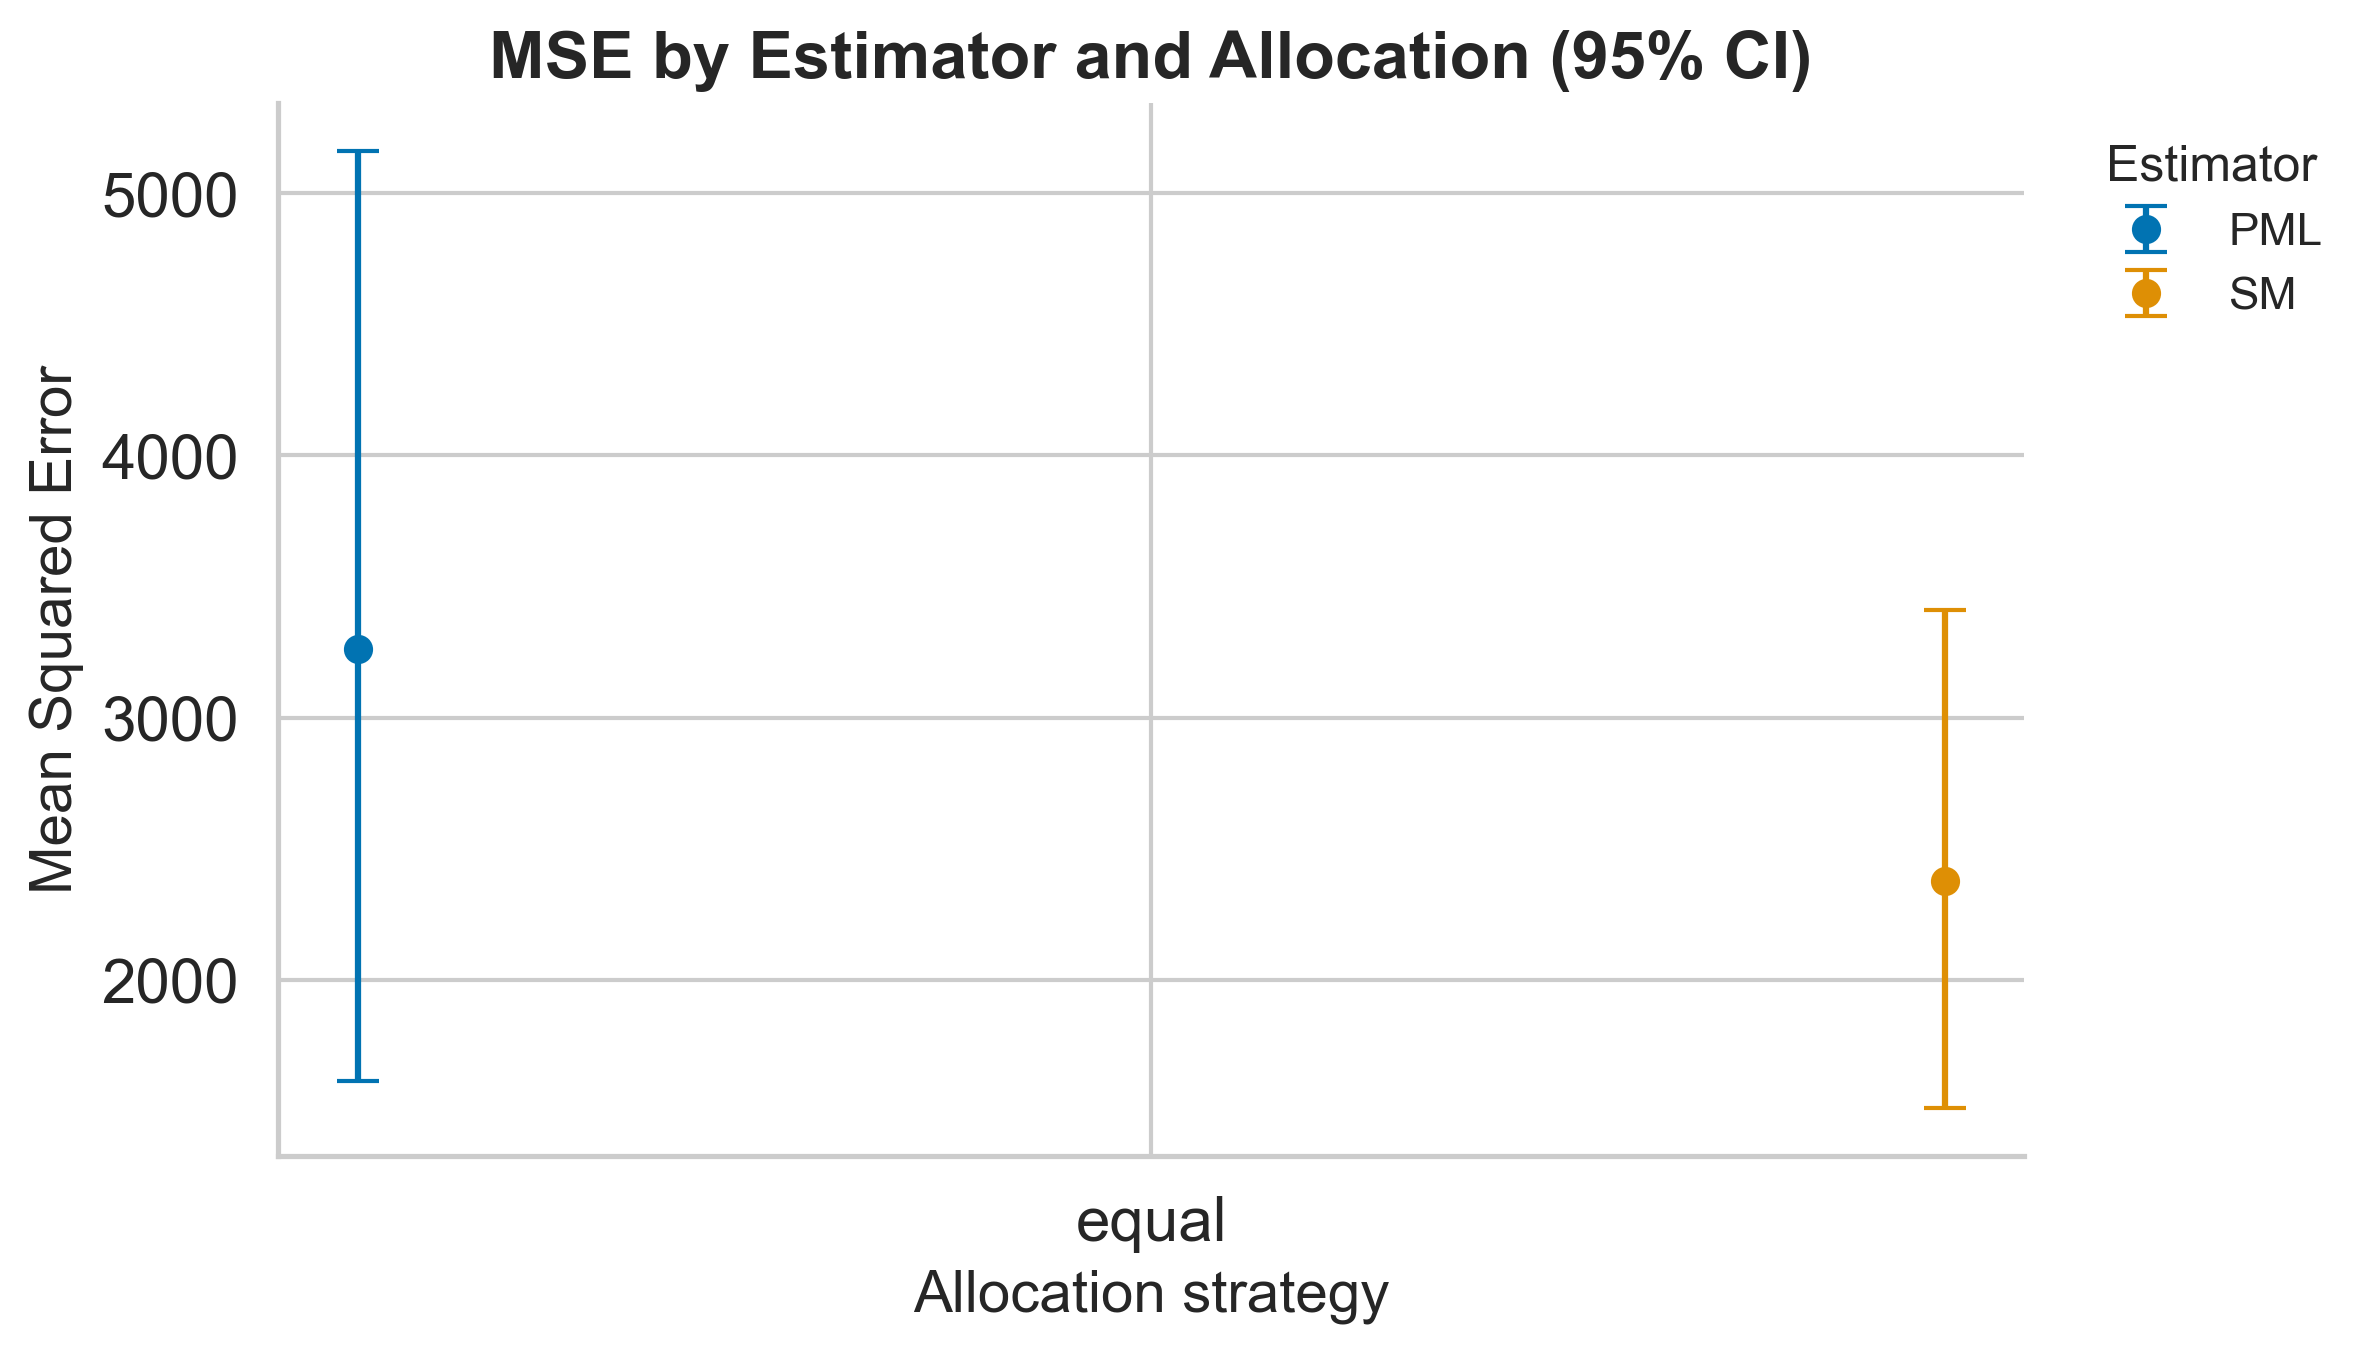

In [13]:
# =======================
# Paper-ready plotting kit
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Iterable, Optional

# -------- Global style (journal look) --------
def _set_paper_style():
    sns.set_theme(style="whitegrid", font_scale=1.35)
    sns.set_palette("colorblind")
    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 600,
        "axes.titleweight": "bold",
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
        "legend.title_fontsize": 12,
        "legend.fontsize": 11
    })

# -------- Helpers --------
def _to_long_df(estimates: Dict[str, np.ndarray],
                y_true: float,
                allocations: Iterable[str]) -> pd.DataFrame:
    """
    Build a tidy DataFrame from arrays of estimates and allocation labels.
    `estimates` must contain keys 'Y_SM' and 'Y_PML' mapping to 1D arrays of equal length.
    `allocations` is a list/array of same length with allocation strategy per run.
    """
    Y_SM = np.asarray(estimates["Y_SM"])
    Y_PML = np.asarray(estimates["Y_PML"])
    alloc = np.asarray(list(allocations))
    assert Y_SM.shape == Y_PML.shape == alloc.shape, "Arrays must have same length."

    df = pd.DataFrame({
        "Y_SM": Y_SM,
        "Y_PML": Y_PML,
        "allocation": alloc
    })
    # long format for plotting
    df_long = df.melt(id_vars="allocation", value_vars=["Y_SM", "Y_PML"],
                      var_name="Estimator", value_name="Estimate")
    df_long["Estimator"] = df_long["Estimator"].str.replace("Y_", "", regex=False)
    df_long["Y_true"] = y_true
    df_long["RelError"] = (df_long["Estimate"] - y_true) / y_true
    return df_long

def _mse_group(df_long: pd.DataFrame, n_boot: int = 5000) -> pd.DataFrame:
    """
    Compute MSE per (allocation, Estimator) and return 95% CI via bootstrap.
    
    Parameters
    ----------
    df_long : pd.DataFrame
        Must contain columns ["allocation", "Estimator", "Estimate", "Y_true"].
    n_boot : int
        Number of bootstrap resamples.
    
    Returns
    -------
    pd.DataFrame
        Columns: ["allocation", "Estimator", "MSE", "CI_low", "CI_high", "n"]
    """
    tmp = df_long.assign(SE=lambda d: (d["Estimate"] - d["Y_true"])**2)
    out_rows = []

    for (alloc, est), group in tmp.groupby(["allocation", "Estimator"]):
        se_values = group["SE"].values
        n = len(se_values)
        
        # Bootstrap the mean of squared errors
        res = bootstrap((se_values,), np.mean, confidence_level=0.95, n_resamples=n_boot, method='percentile')
        mse = se_values.mean()
        ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
        
        out_rows.append({
            "allocation": alloc,
            "Estimator": est,
            "MSE": mse,
            "CI_low": ci_low,
            "CI_high": ci_high,
            "n": n
        })
    
    return pd.DataFrame(out_rows)

# -------- Figures --------
def plot_estimator_distribution(estimates: Dict[str, np.ndarray],
                                y_true: float,
                                allocations: Iterable[str],
                                kind: str = "violin",
                                save: Optional[str] = None):
    """
    Distribution of Y_SM vs Y_PML across runs, split by allocation.
    kind: 'violin' or 'box'
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)

    plt.figure(figsize=(8.2, 4.8))
    if kind == "violin":
        ax = sns.violinplot(data=df, x="allocation", y="Estimate", hue="Estimator",
                            inner="quartile", cut=0)
    else:
        ax = sns.boxplot(data=df, x="allocation", y="Estimate", hue="Estimator",
                         width=0.55, linewidth=1.2)
    # True line
    ax.axhline(y_true, color="black", linestyle="--", linewidth=1.2, label="True value")
    ax.set_xlabel("Allocation strategy")
    ax.set_ylabel("Estimator value")
    ax.set_title("Distribution of Estimators across runs")
    # combine legend entries (avoid duplicate line handle)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="Estimator")
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

def plot_relative_error(estimates: Dict[str, np.ndarray],
                        y_true: float,
                        allocations: Iterable[str],
                        save: Optional[str] = None):
    """
    Relative error = (estimate - Y_true)/Y_true for SM vs PML, per allocation.
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)

    plt.figure(figsize=(8.2, 4.8))
    ax = sns.boxplot(
        data=df,
        x="allocation",
        y="RelError",
        hue="Estimator",
        palette=["steelblue", "darkorange"],
        showcaps=True,
        fliersize=2,
        boxprops={"alpha": 0.7}
    )
    ax.axhline(0, color="black", linestyle="--", linewidth=1.2)
    ax.set_xlabel("Allocation strategy")
    ax.set_ylabel("Relative error")
    ax.set_title("Relative Error by Estimator and Allocation")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Estimator")

    sns.despine()
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

def plot_mse(estimates: Dict[str, np.ndarray],
             y_true: float,
             allocations: Iterable[str],
             save: Optional[str] = None):
    """
    Plot MSE per estimator and allocation using pre-computed bootstrap CI.
    """
    _set_paper_style()
    df = _to_long_df(estimates, y_true, allocations)
    mse_df = _mse_group(df)

    print(mse_df)
    
    plt.figure(figsize=(8.2, 4.8))
    
    # Get unique estimators and allocations for positioning
    estimators = mse_df["Estimator"].unique()
    allocations_list = mse_df["allocation"].unique()
    n_alloc = len(allocations_list)
    width = 0.8 / len(estimators)  # width of each point
    
    for i, est in enumerate(estimators):
        est_df = mse_df[mse_df["Estimator"] == est]
        x = np.arange(n_alloc) - 0.4 + i * width + width/2
        y = est_df["MSE"]
        yerr = [y - est_df["CI_low"], est_df["CI_high"] - y]  # asymmetric error bars
        plt.errorbar(
            x, y, yerr=yerr, fmt='o', label=est, capsize=5
        )
    
    plt.xticks(np.arange(n_alloc), allocations_list)
    plt.xlabel("Allocation strategy")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE by Estimator and Allocation (95% CI)")
    plt.legend(title="Estimator", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

# =======================
# Minimal example of use:
# =======================

#first_run
simulation = Simulation()
simulation_init_results = simulation.run_pipeline()

Y_true = np.sum(simulation_init_results["population"]["y"])

# Suppose you have arrays from R runs with the same length:
R = 30
estimates = {
     "Y_SM": np.array([Simulation(reproduce=False).run_pipeline()["estimates"]["Y_SM"] for rr in range(R)]),   
     "Y_PML": np.array([Simulation(reproduce=False).run_pipeline()["estimates"]["Y_PML"] for rr in range(R)])}

allocations = np.repeat("equal", R)  # e.g., ["prop-x", "equal", "cost-opt", ...] per run


#
plot_estimator_distribution(estimates, Y_true, allocations, kind="boxplot", save="fig_test.pdf")
plot_relative_error(estimates, Y_true, allocations, save="fig_test.pdf")
plot_mse(estimates, Y_true, allocations, save="fig_test.pdf")
